In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import os
import sys
import pickle

import elephant as  eleph
import neo.core as neo
from quantities import s, ms, kHz
import quantities as pq

import utils
from tqdm import tqdm

import seaborn as sns
plt.rcParams.update({'font.size': 20})

In [66]:
# Select File
dandiset_id =  utils.dandiset_id
dandi_dirpath = utils.dandi_dirpath
dandi_filepath = utils.dandi_filepath
filenames = utils.filenames
filenames = sorted(filenames)
filename = filenames[0]

In [67]:
# Get Probe Info
probe_a, probe_b, probe_c, probe_d = utils.load_probe_dicts([filename])

In [68]:
# Load raw data
nwb = utils.load_dandi(filename, dandiset_id=dandiset_id, dandi_dirpath=dandi_dirpath)
df_units = nwb.units.to_dataframe()
df_rf = nwb.intervals['RF mapping_presentations'].to_dataframe()

Processing file: sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed us

In [ ]:
df_units.columns

Index(['spike_times', 'electrodes', 'waveform_mean', 'waveform_sd',
       'unit_name', 'firing_range', 'estimated_x', 'isi_violations_count',
       'drift_std', 'amplitude', 'l_ratio', 'sync_spike_4', 'amplitude_cutoff',
       'nn_hit_rate', 'half_width', 'estimated_z', 'sync_spike_8',
       'peak_trough_ratio', 'nn_miss_rate', 'estimated_y', 'sync_spike_2',
       'repolarization_slope', 'ks_unit_id', 'drift_ptp',
       'original_cluster_id', 'rp_violations', 'decoder_probability',
       'velocity_below', 'd_prime', 'amplitude_cv_range', 'drift_mad',
       'num_positive_peaks', 'device_name', 'amplitude_median',
       'rp_contamination', 'snr', 'exp_decay', 'num_negative_peaks',
       'peak_to_valley', 'recovery_slope', 'firing_rate', 'default_qc',
       'spread', 'decoder_label', 'sliding_rp_violation', 'silhouette',
       'isolation_distance', 'presence_ratio', 'amplitude_cv_median',
       'extremum_channel_index', 'isi_violations_ratio', 'shank',
       'velocity_above'

In [ ]:
def get_stim_onsets_offsets(df_rf, combination_xy, orientation='0'):
    x, y  = combination_xy
    df_sub = df_rf[
        (df_rf['X'] == str(float(x))) &
        (df_rf['Y'] == str(float(y))) &
        (df_rf['Orientation'] == str(float(orientation)))
    ]
    return (df_sub['start_time'].values * pq.s, df_sub['stop_time'].values * pq.s)

def time_slice_spike_train(spike_train, start, stop):
    if (stop < spike_train.t_start) or ( start > spike_train.t_stop):
        return []
    else:
        if start < spike_train.t_start:
            start = spike_train.t_start
        if stop > spike_train.t_stop:
            stop = spike_train.t_stop
    
    return spike_train.time_slice(start, stop)

def index_to_angle(index, df_rf=df_rf):
    unique_x = np.unique(df_rf['X'])
    x_pos = np.sort(unique_x.astype(float))

    if isinstance(index, (list, np.ndarray)):
        return [x_pos[i] for i in index]
    else:
        return x_pos[index]

In [ ]:
PROBE = 'c'
DELAY = 100 *pq.ms
unit_idx = probe_c[list(probe_c.keys())[0]]

unique_x = np.unique(df_rf['X'])
unique_y = np.unique(df_rf['Y'])
x_pos = np.sort(unique_x.astype(float))
y_pos = np.sort(unique_y.astype(float))
unique_orientations = np.unique(df_rf['Orientation'])
combinations_xy = [(x, y) for x in unique_x for y in unique_y]

results = []
for idx in tqdm(unit_idx):

    unit_name = df_units.loc[idx, 'unit_name']
    spike_times = df_units.loc[idx, 'spike_times']
    spike_times = neo.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

    for orientation in unique_orientations.astype(float):
        R = np.zeros((5, len(x_pos), len(y_pos)))
        for (x,y) in combinations_xy:
            x_i = np.digitize(float(x), x_pos)-1
            y_i = np.digitize(float(y), y_pos)-1

            onsets, offsets = get_stim_onsets_offsets(df_rf, combination_xy=(x,y), orientation=orientation)
            for i, (onset, offset) in enumerate(zip(onsets, offsets)):
                n_spikes = len(time_slice_spike_train(spike_times, onset+DELAY, offset))
                R[i, x_i, y_i] = n_spikes / ((offset - onset - DELAY).rescale(s).magnitude)
            
            
        E = np.mean(R)  # Grand mean - add small value to avoid division by zero
        O = np.mean(R, axis=0) # mean response grid
        chi_squared = np.sum((O - E)**2 / (E+1e-10))

        n_shuffle = 1000
        chi_squared_shuffled = np.zeros(n_shuffle)
        for i in range(n_shuffle):
            R_shuffled = np.random.permutation(R.flatten())
            R_shuffled = R_shuffled.reshape(R.shape)
            O_shuffled = np.mean(R_shuffled, axis=0)
            chi_squared_shuffled[i] = np.sum((O_shuffled - E)**2 / (E+1e-10))

        p_value = (np.sum(chi_squared_shuffled > chi_squared)+1 ) / (n_shuffle+1)

        std = np.std(R)
        z_score_response = (O - E) / (std+1e-10)  # add small value to avoid division by zero

        results.append(pd.DataFrame({
                                'unit_name': [unit_name],
                                'file': [dandi_filepath],
                                'mean_response' : [E],
                                'z_score_response': [z_score_response],
                                'orientation': [orientation],
                                'p_value': [p_value],
                                'mean_rate': [np.mean(R)],
                                'probe': [PROBE],
                                })
        )

100%|██████████| 698/698 [17:41<00:00,  1.52s/it]


In [ ]:
results_c = pd.concat(results, ignore_index=True)
results_c

,unit_name,file,mean_response,z_score_response,orientation,p_value,mean_rate,probe
0,c961fb74-0d82-44db-acb7-809574ca6252,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,19.535343,"[[0.2180788093163998, -0.26679654003915704, 0....",0.000000,0.591409,19.535343,c
1,c961fb74-0d82-44db-acb7-809574ca6252,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,20.303455,"[[-0.15764670661094723, 0.491693464748648, -0....",0.785398,0.544456,20.303455,c
2,c961fb74-0d82-44db-acb7-809574ca6252,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,19.839903,"[[0.662722354140438, -0.1384690484037228, 0.30...",1.570796,0.102897,19.839903,c
3,0510c290-44d7-4223-8cb0-e0a42ca92423,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,12.776193,"[[-0.9608931686232007, -0.9608931686232007, 0....",0.000000,0.004995,12.776193,c
4,0510c290-44d7-4223-8cb0-e0a42ca92423,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,13.464948,"[[0.06906358847421393, -0.925036080805571, -0....",0.785398,0.071928,13.464948,c
...,...,...,...,...,...,...,...,...
2089,6232034a-21a2-4882-8f1b-21c24646a4ab,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,0.295898,"[[-0.22792115287482154, -0.22792115287482154, ...",0.785398,0.488511,0.295898,c
2090,6232034a-21a2-4882-8f1b-21c24646a4ab,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,0.281104,"[[0.6870349412603707, -0.2105398079662308, -0....",1.570796,0.309690,0.281104,c
2091,b5a54e90-9807-4ae2-ab13-498dd6db4d60,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,16.396620,"[[0.6393037061927169, 0.43692430231422524, -0....",0.000000,0.635365,16.396620,c
2092,b5a54e90-9807-4ae2-ab13-498dd6db4d60,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,15.902810,"[[-0.23715946256047787, -0.6550635715296378, -...",0.785398,0.213786,15.902810,c


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/2749534087.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Estimated X Position ($\mu$m)')
/tmp/ipykernel_42220/2749534087.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Estimated Y Position ($\mu$m)')


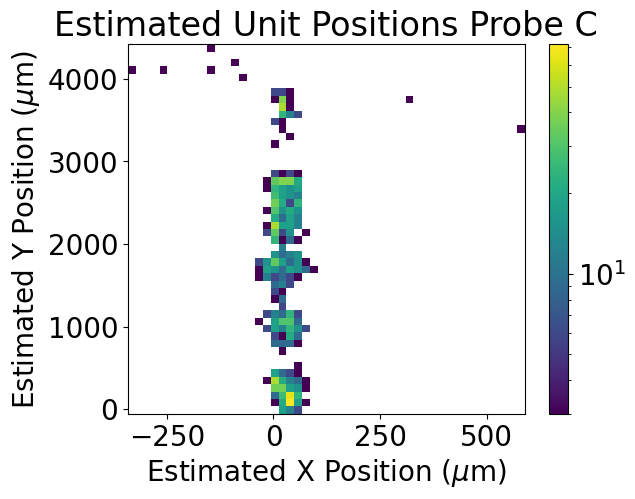

In [ ]:
results_c['estimated_x'] = results_c['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_x'].values[0])
results_c['estimated_y'] = results_c['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_y'].values[0])
results_c['estimated_z'] = results_c['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_z'].values[0])

fig = plt.figure()
ax = fig.add_subplot()

hist = ax.hist2d(results_c['estimated_x'], results_c['estimated_y'], bins=50, cmap='viridis', norm=mpl.colors.LogNorm())
ax.set_xlabel('Estimated X Position ($\mu$m)')
ax.set_ylabel('Estimated Y Position ($\mu$m)')
ax.set_title('Estimated Unit Positions Probe C')
fig.colorbar(hist[3], ax=ax)

(array([ 8.,  9., 12., 11.,  1.,  0.,  0.,  2.,  3.,  6.,  0.,  0.,  1.,
         2.,  1.,  1.,  3., 21., 13., 15., 11., 21.,  1.,  0.,  0.,  1.,
         0.,  4.,  9., 11.]),
 array([ -56.23      ,   73.12633333,  202.48266667,  331.839     ,
         461.19533333,  590.55166667,  719.908     ,  849.26433333,
         978.62066667, 1107.977     , 1237.33333333, 1366.68966667,
        1496.046     , 1625.40233333, 1754.75866667, 1884.115     ,
        2013.47133333, 2142.82766667, 2272.184     , 2401.54033333,
        2530.89666667, 2660.253     , 2789.60933333, 2918.96566667,
        3048.322     , 3177.67833333, 3307.03466667, 3436.391     ,
        3565.74733333, 3695.10366667, 3824.46      ]),
 <BarContainer object of 30 artists>)

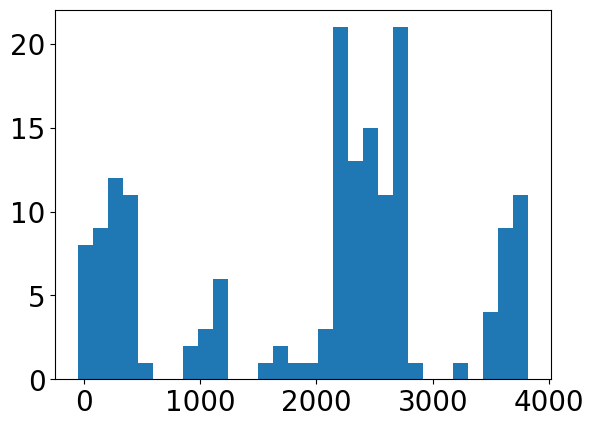

In [ ]:
plt.hist(df_tmp['estimated_y'], bins=30)

In [ ]:
filename

'sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb'

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/1867173883.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/1867173883.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/1867173883.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/1867173883.py:65:

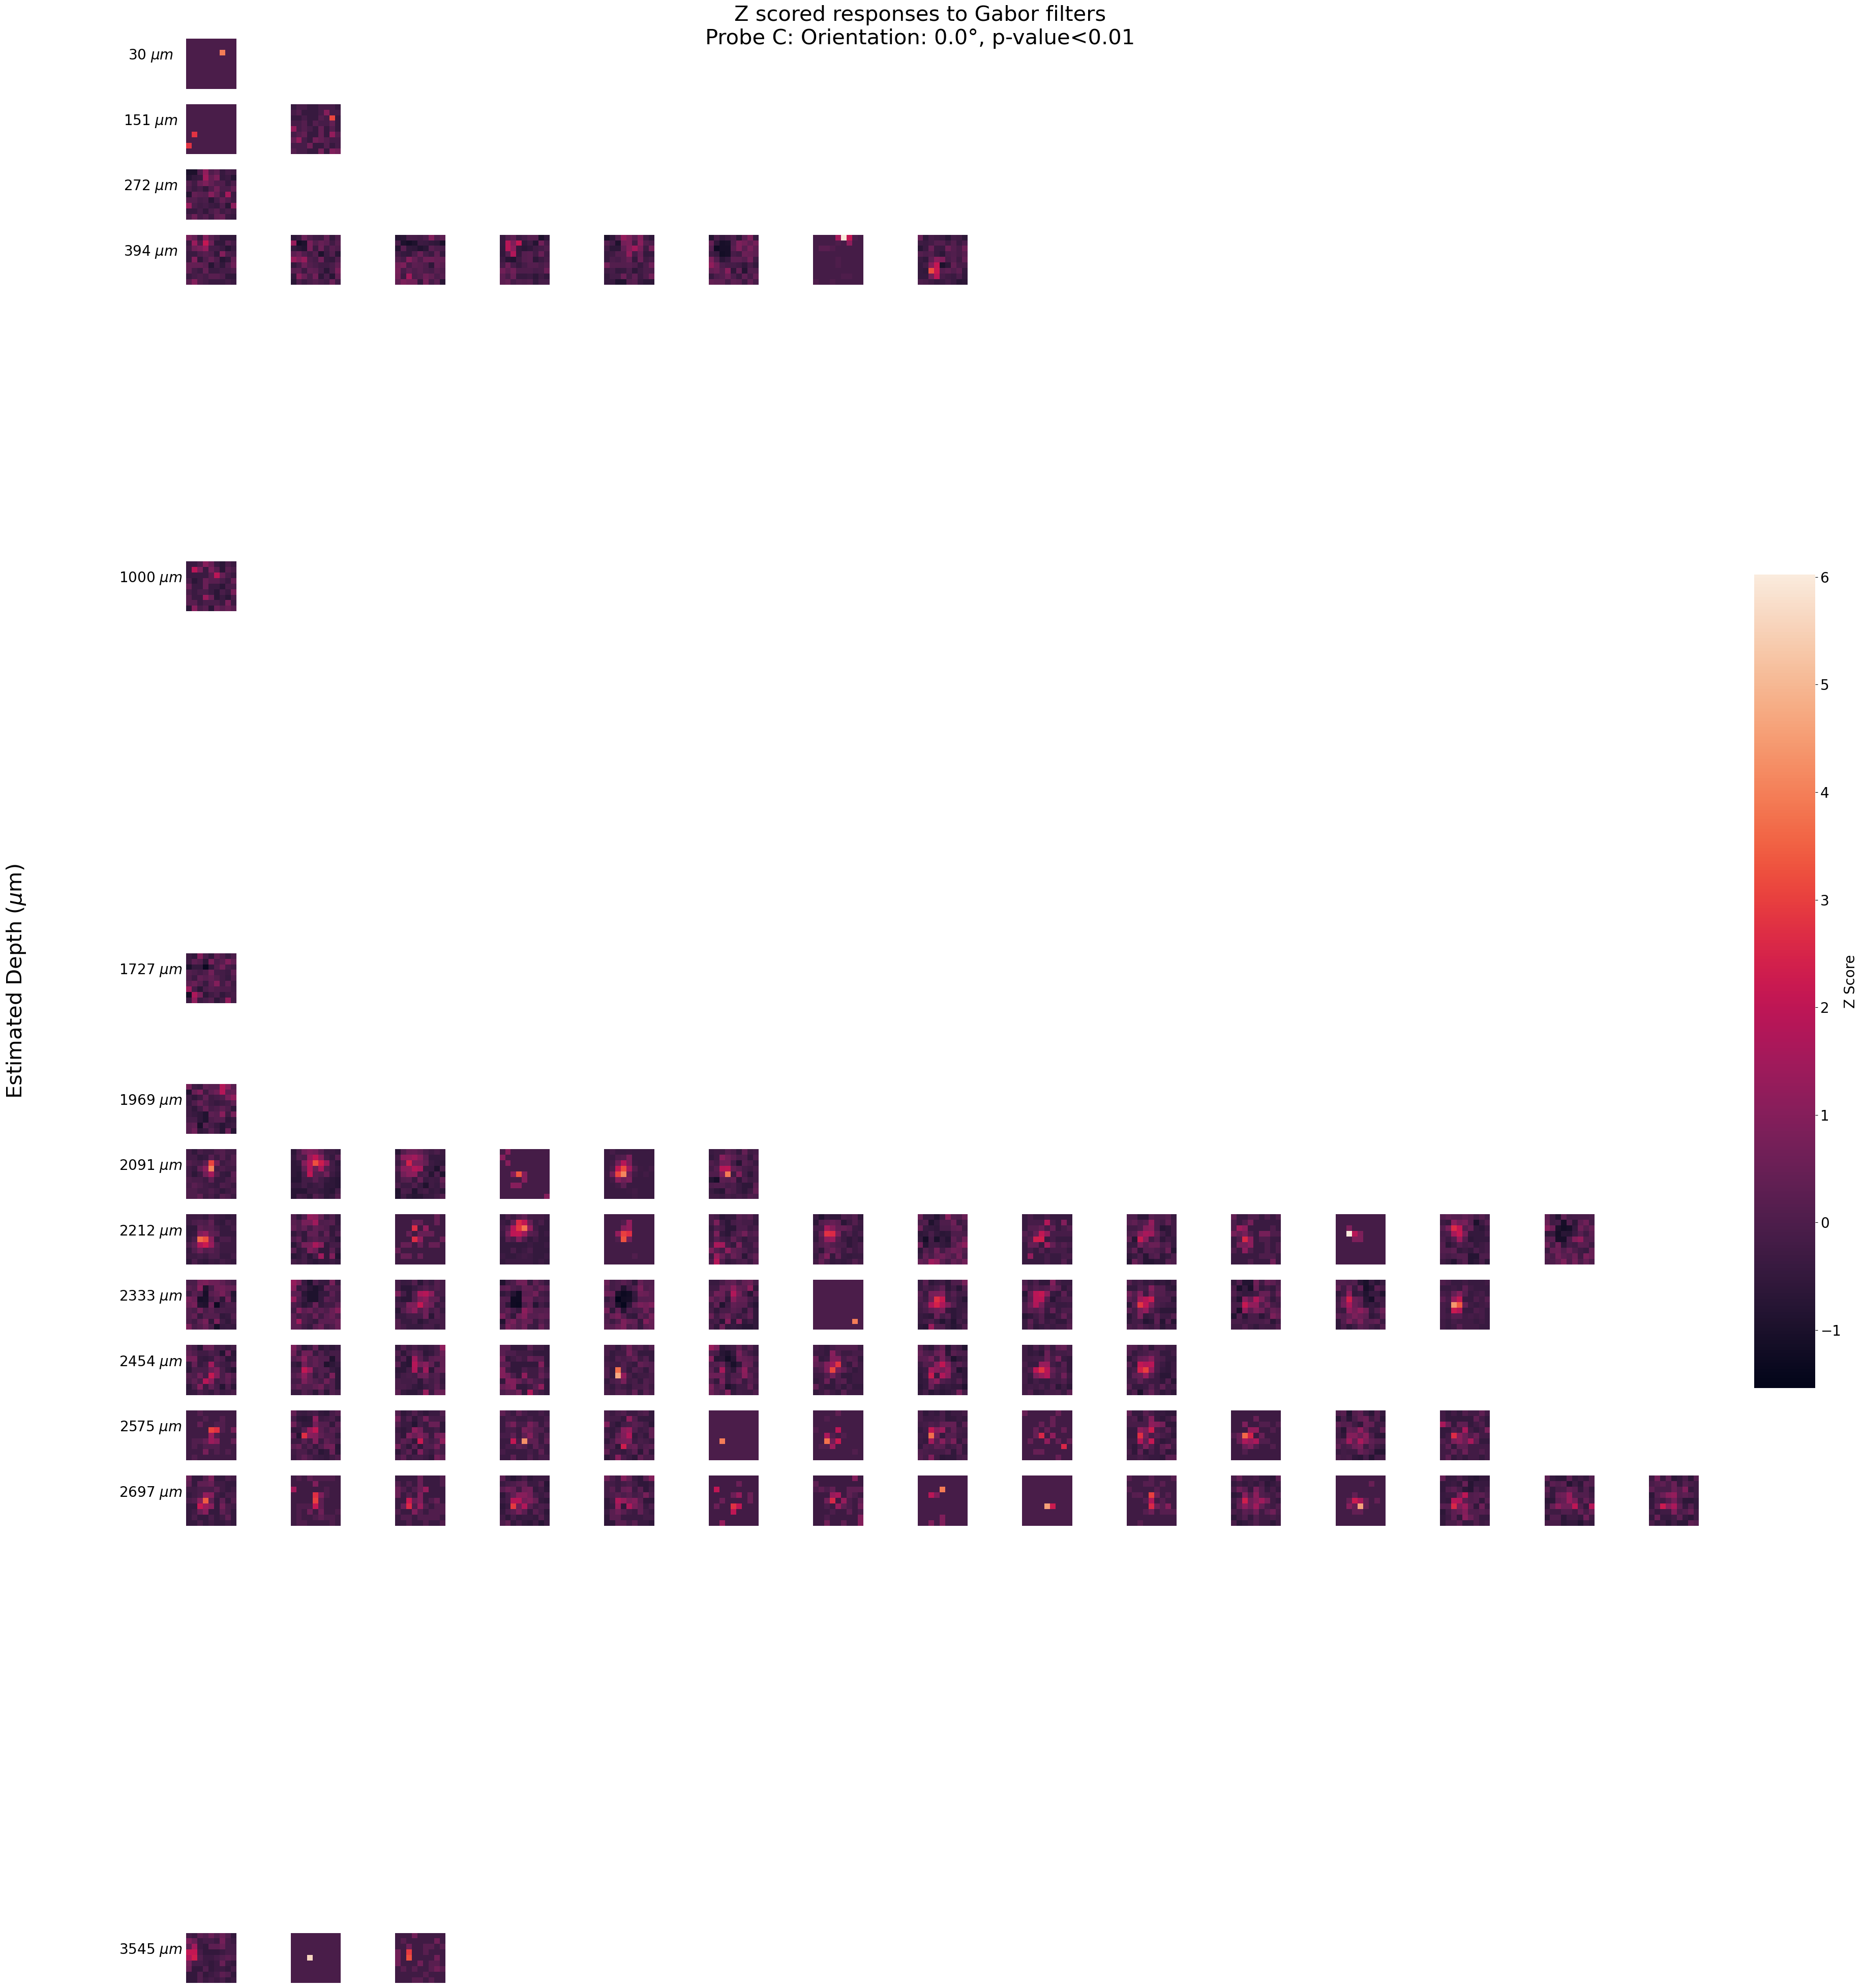

In [ ]:
n_ybins = 30
p_value_threshold = 0.01
orientation = 0.0

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe C: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-c__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

In [ ]:
df_rf['Orientation'].unique()

array(['0.0', '1.5707963267948966', '0.7853981633974483'], dtype=object)

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/834383832.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/834383832.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/834383832.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/834383832.py:65: Use

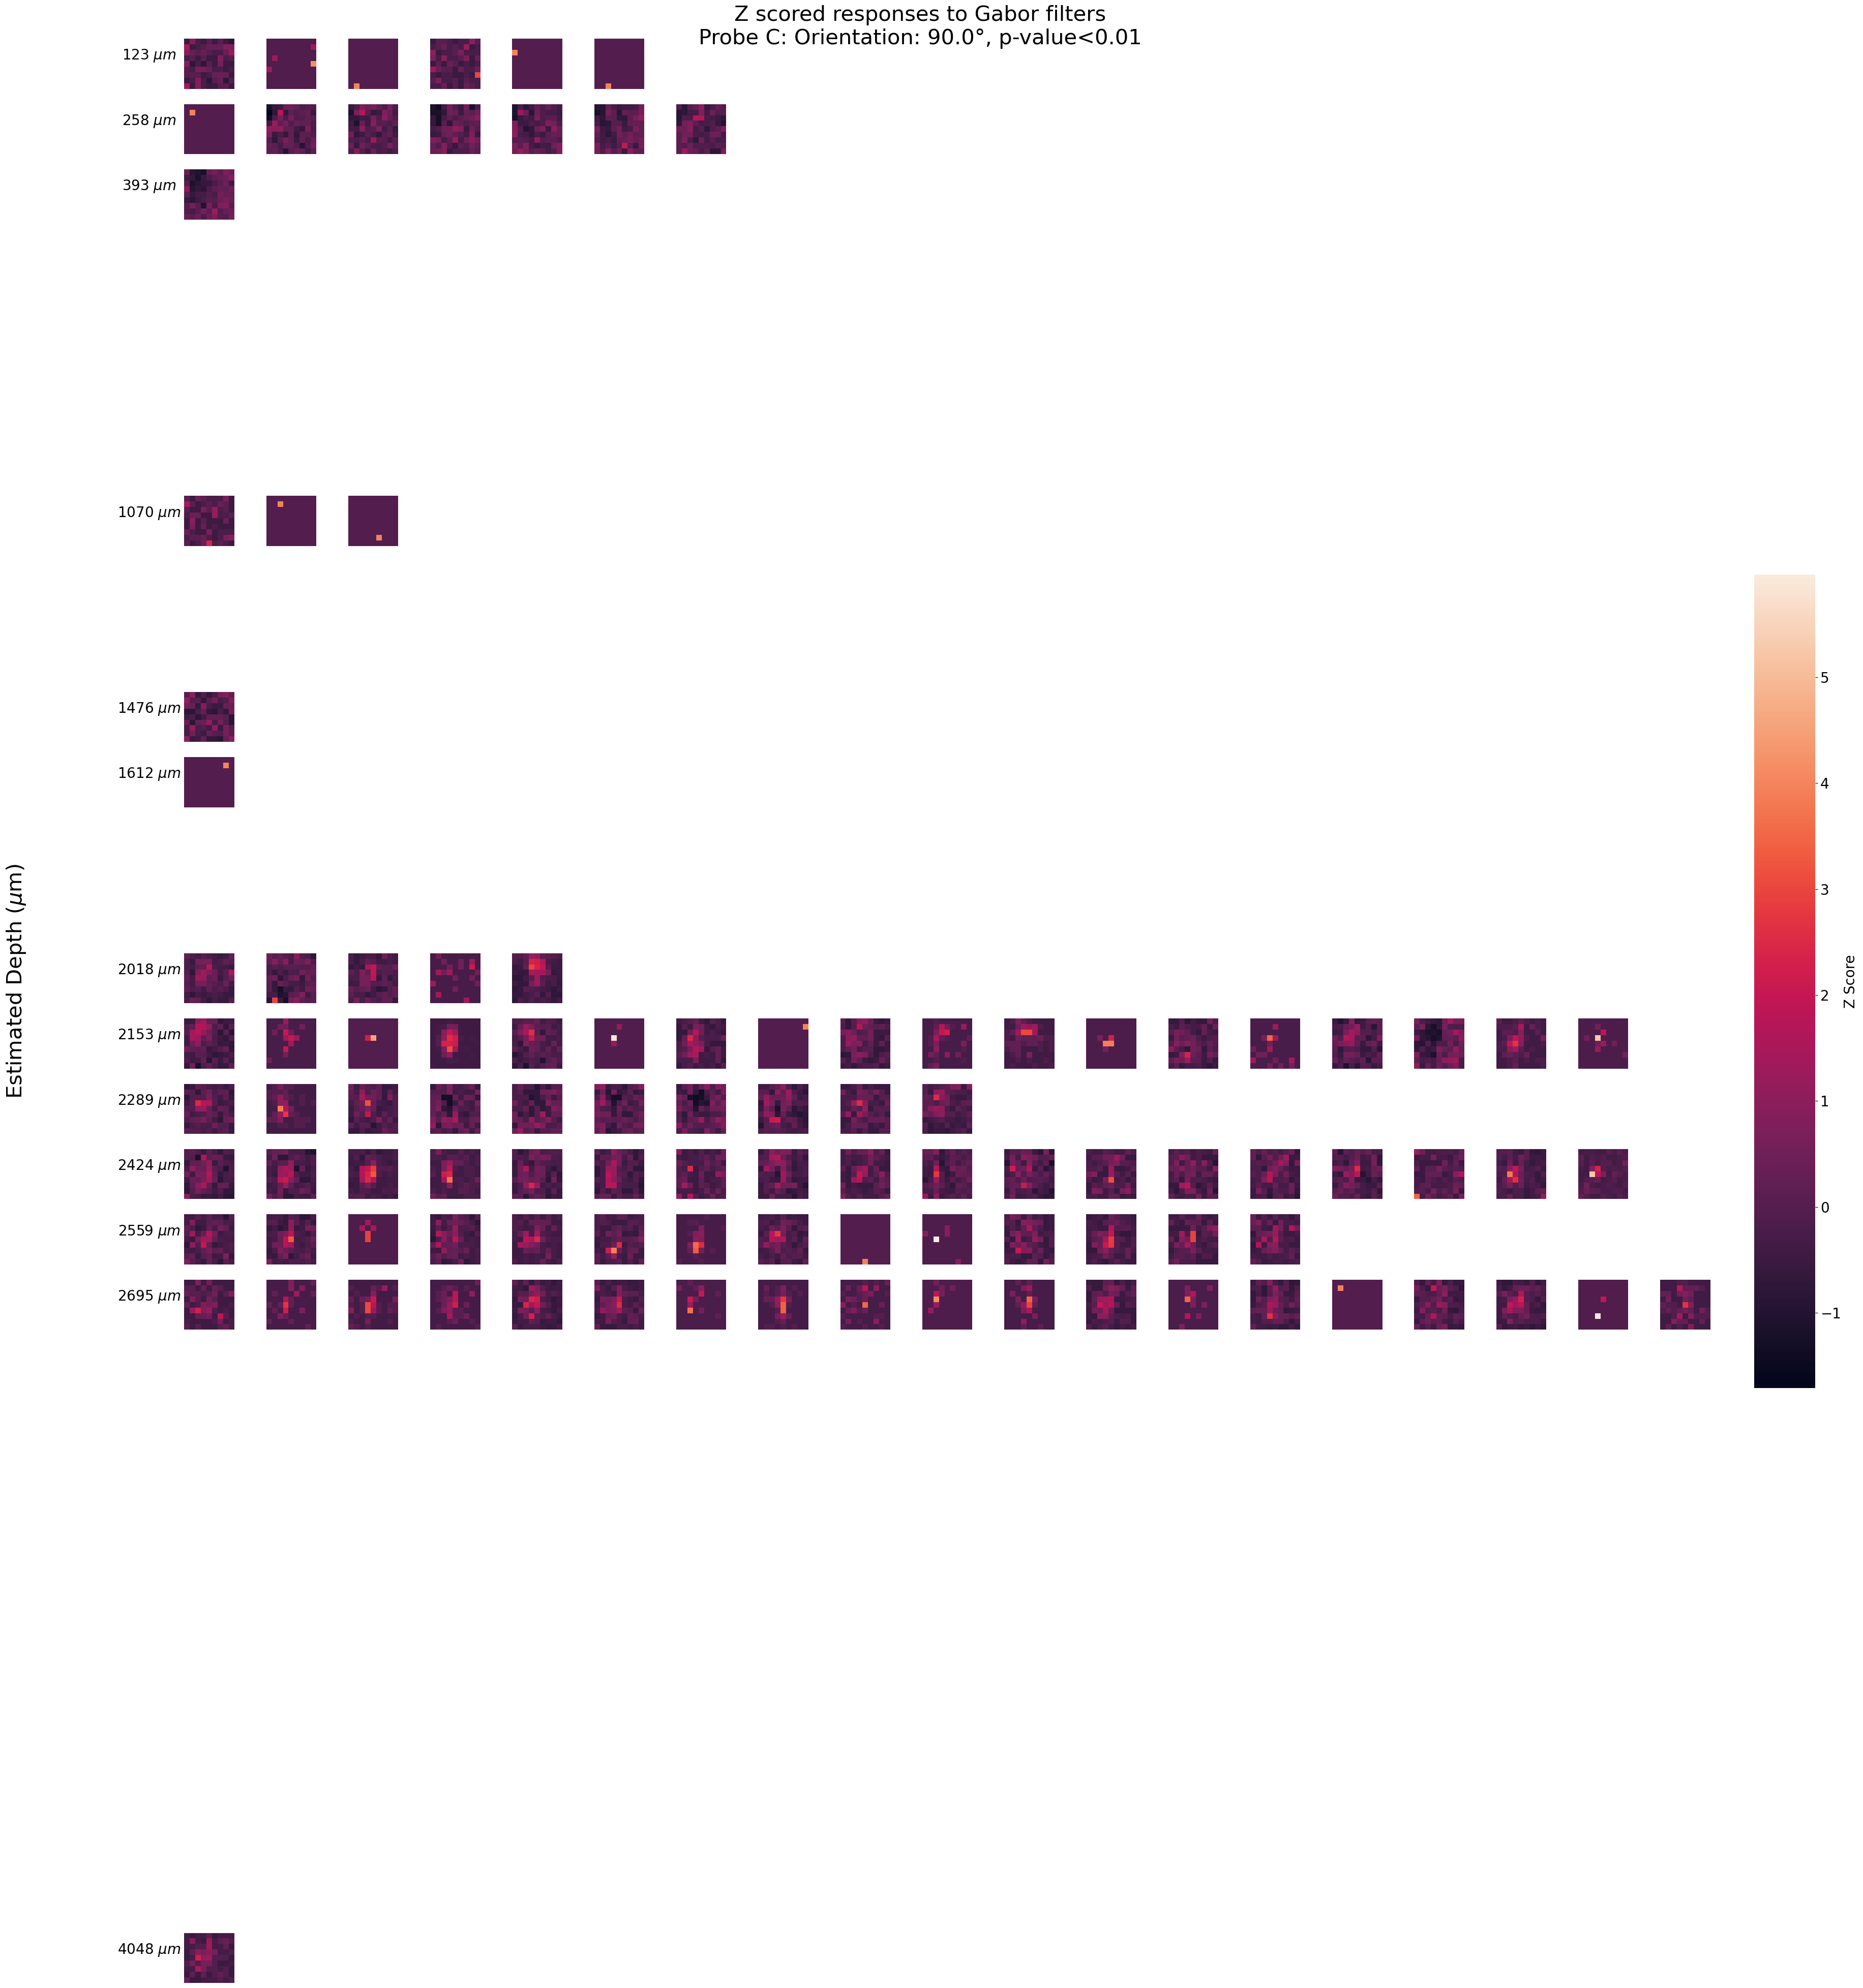

In [ ]:
n_ybins = 30
p_value_threshold = 0.01
orientation = float(df_rf['Orientation'].unique()[1]) 

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe C: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-c__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/2522194048.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/2522194048.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/2522194048.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/2522194048.py:65:

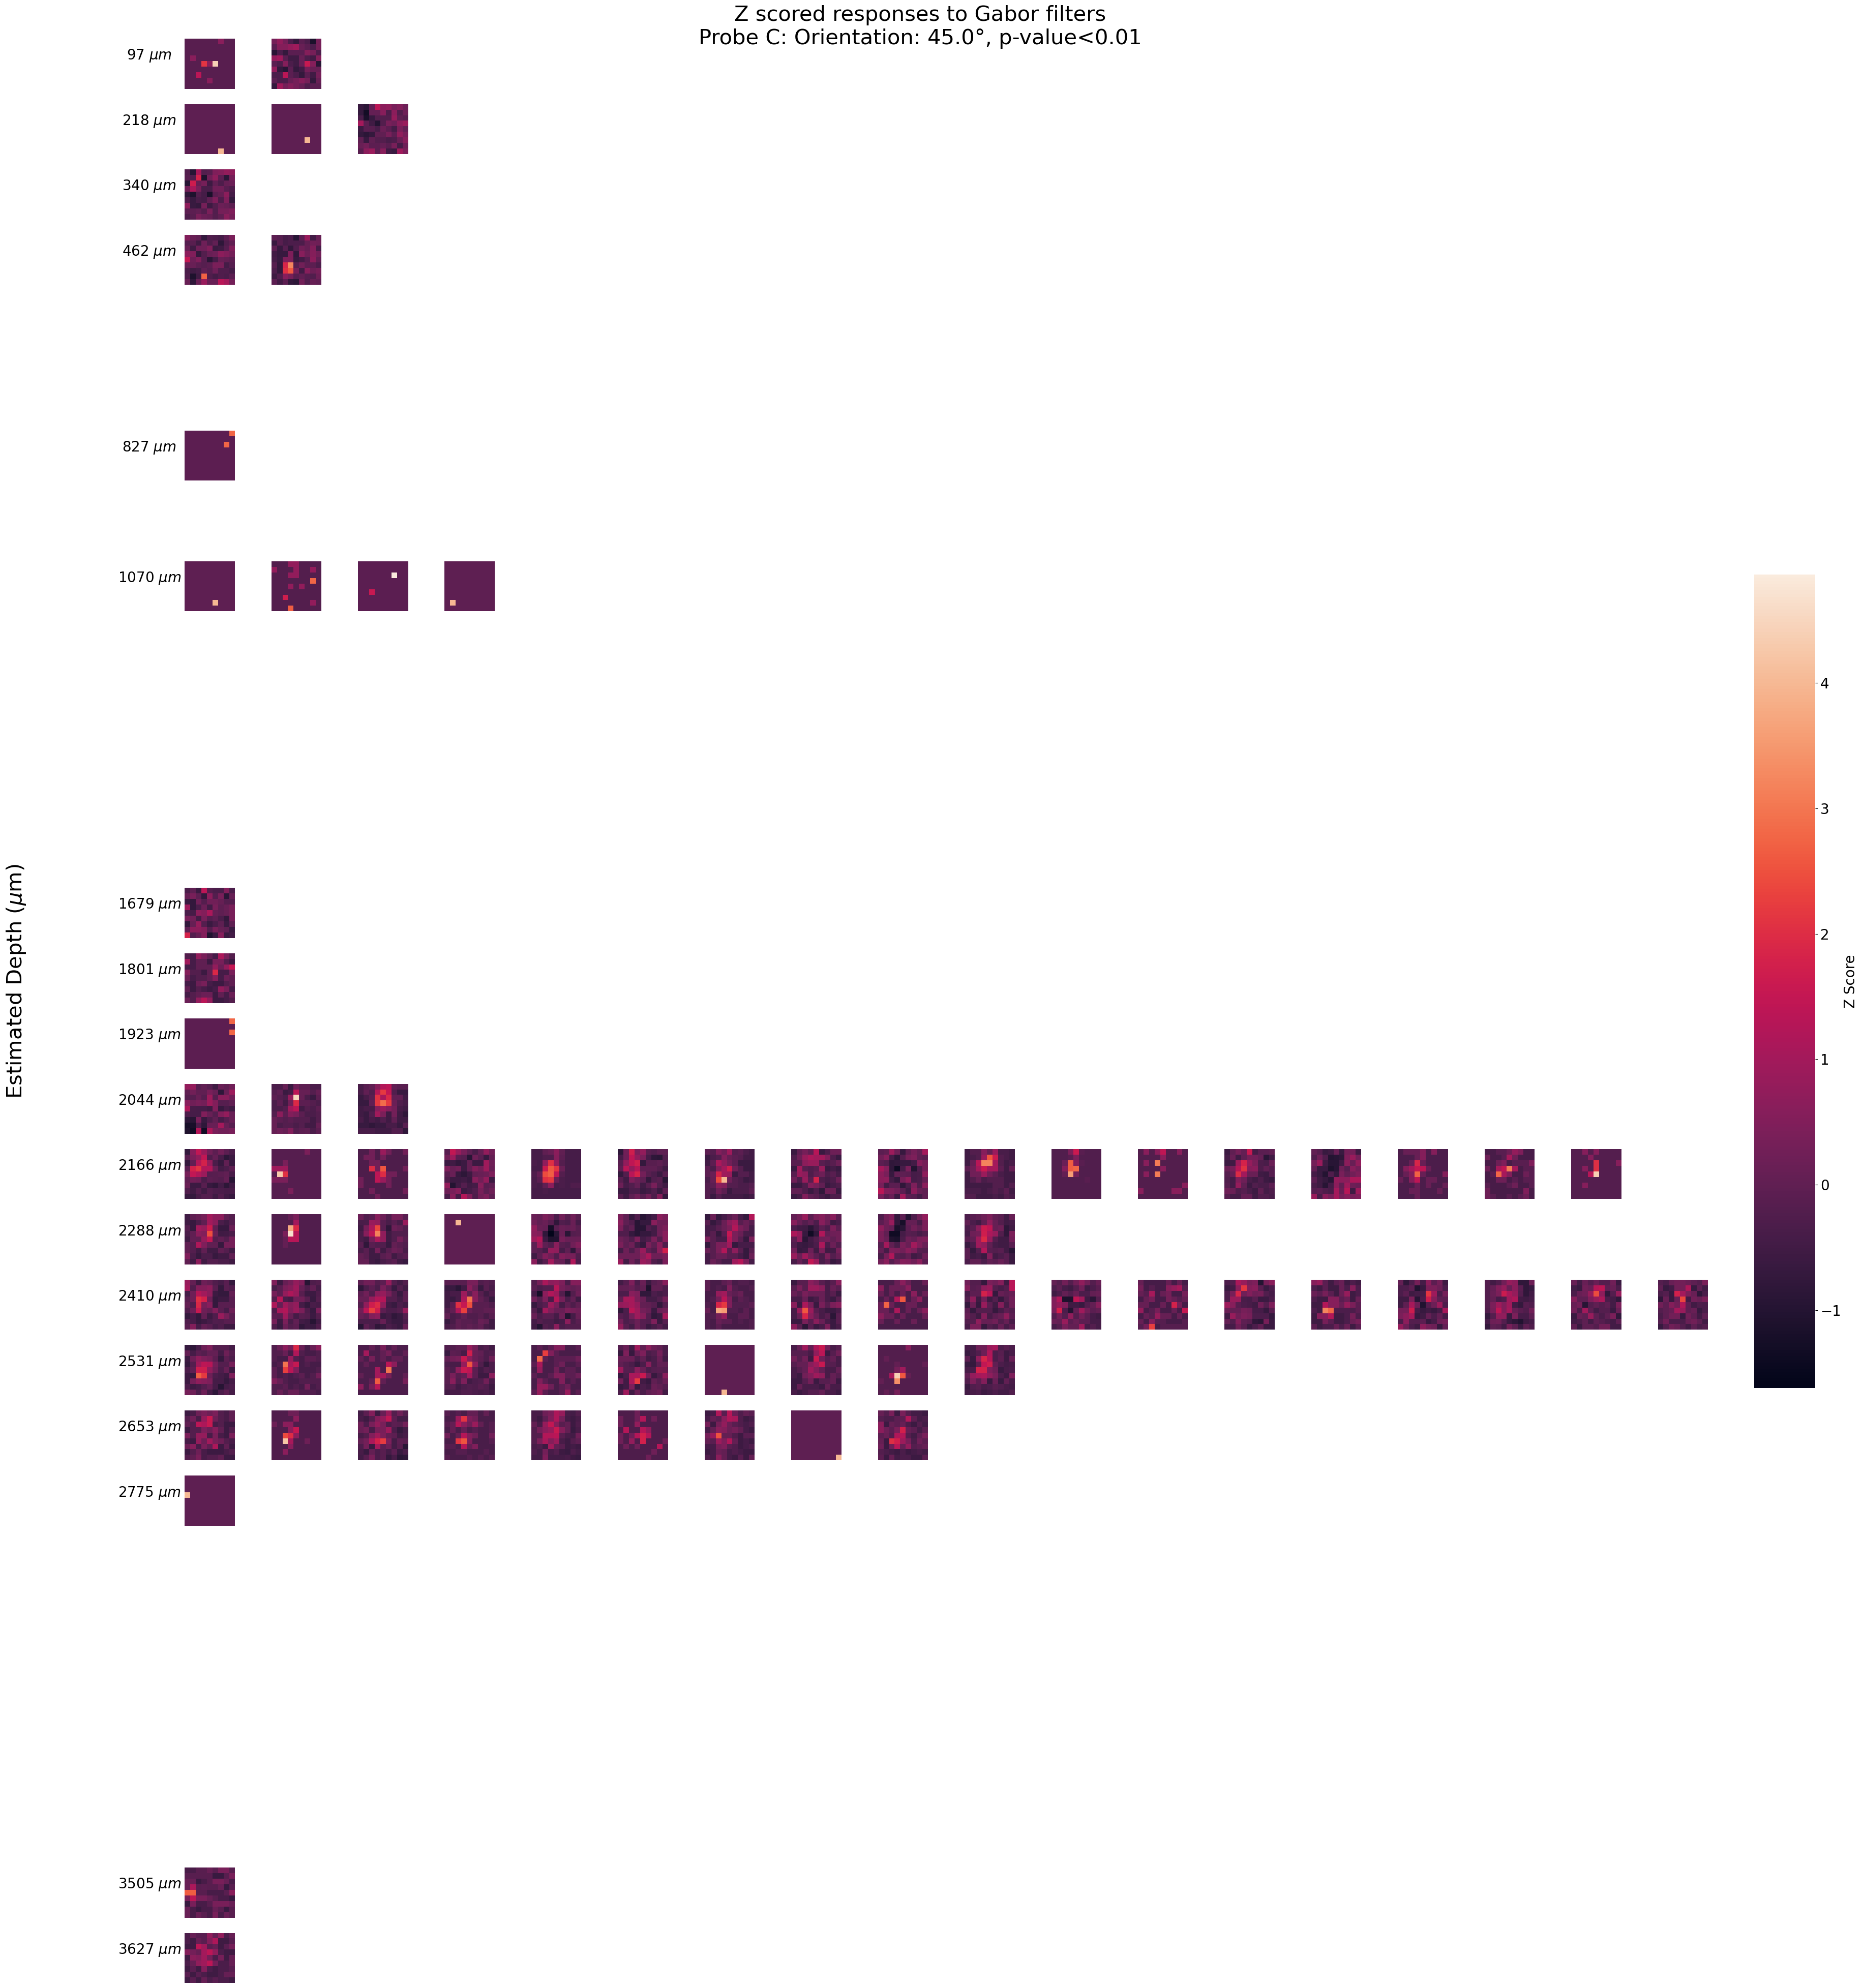

In [74]:
n_ybins = 30
p_value_threshold = 0.01
orientation = float(df_rf['Orientation'].unique()[2]) 

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe C: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-{PROBE}__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

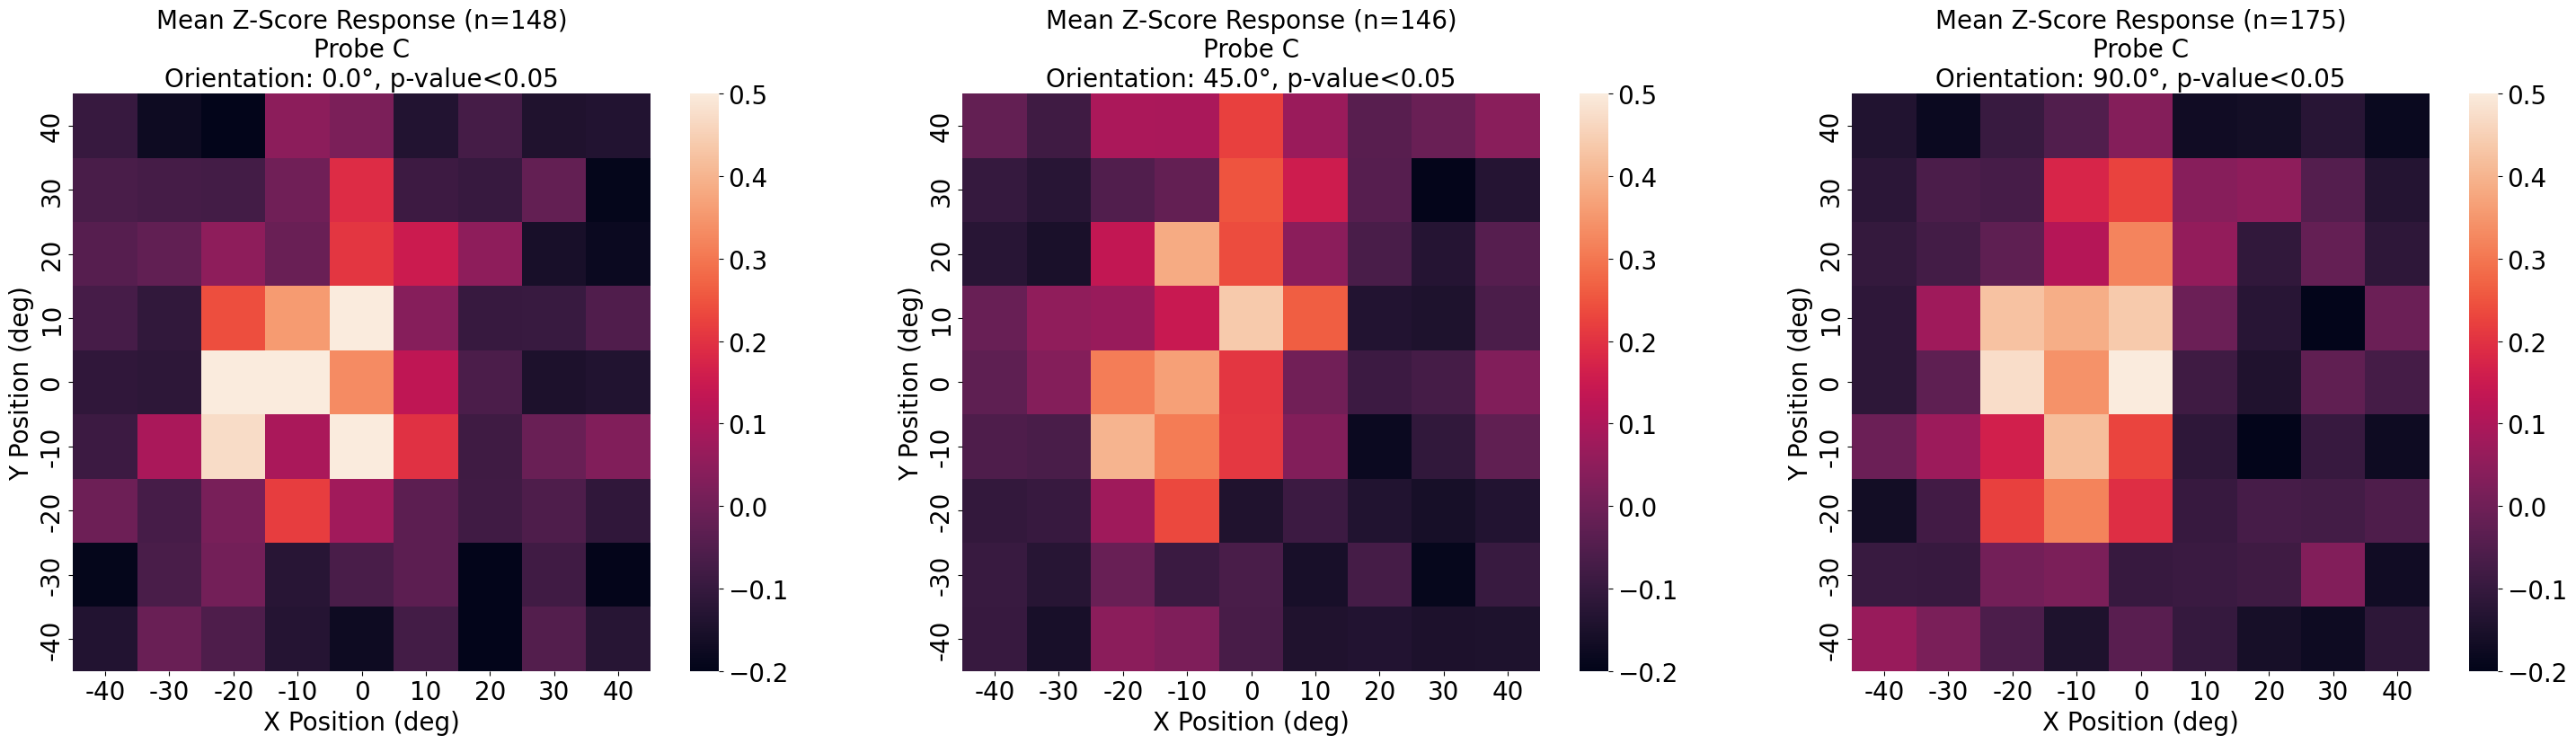

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=False)
axs = axs.flatten()

for i, ax in enumerate(axs):
    orientation = float(unique_orientations[i])
    p_value_threshold = 0.05
    df_tmp = results_c[(results_c['p_value']<p_value_threshold) & 
                       (results_c['orientation'] == orientation) &
                       (results_c['mean_rate'] > 0)
                    ]
    df_tmp.reset_index(drop=True, inplace=True)

    all_z_responses = df_tmp['z_score_response'].values
    mean = np.mean(all_z_responses, axis=0)

    sns.heatmap(mean, ax=ax,vmin=-.2, vmax=.5)
    _ = ax.set_xticklabels(x_pos.astype(int))
    _ = ax.set_yticklabels(reversed(y_pos.astype(int)))

    ax.set_title(f'Mean Z-Score Response (n={len(df_tmp)})\nProbe C\nOrientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=20)
    ax.set_aspect('equal')
    ax.set_xlabel('X Position (deg)')
    ax.set_ylabel('Y Position (deg)')

f.tight_layout()

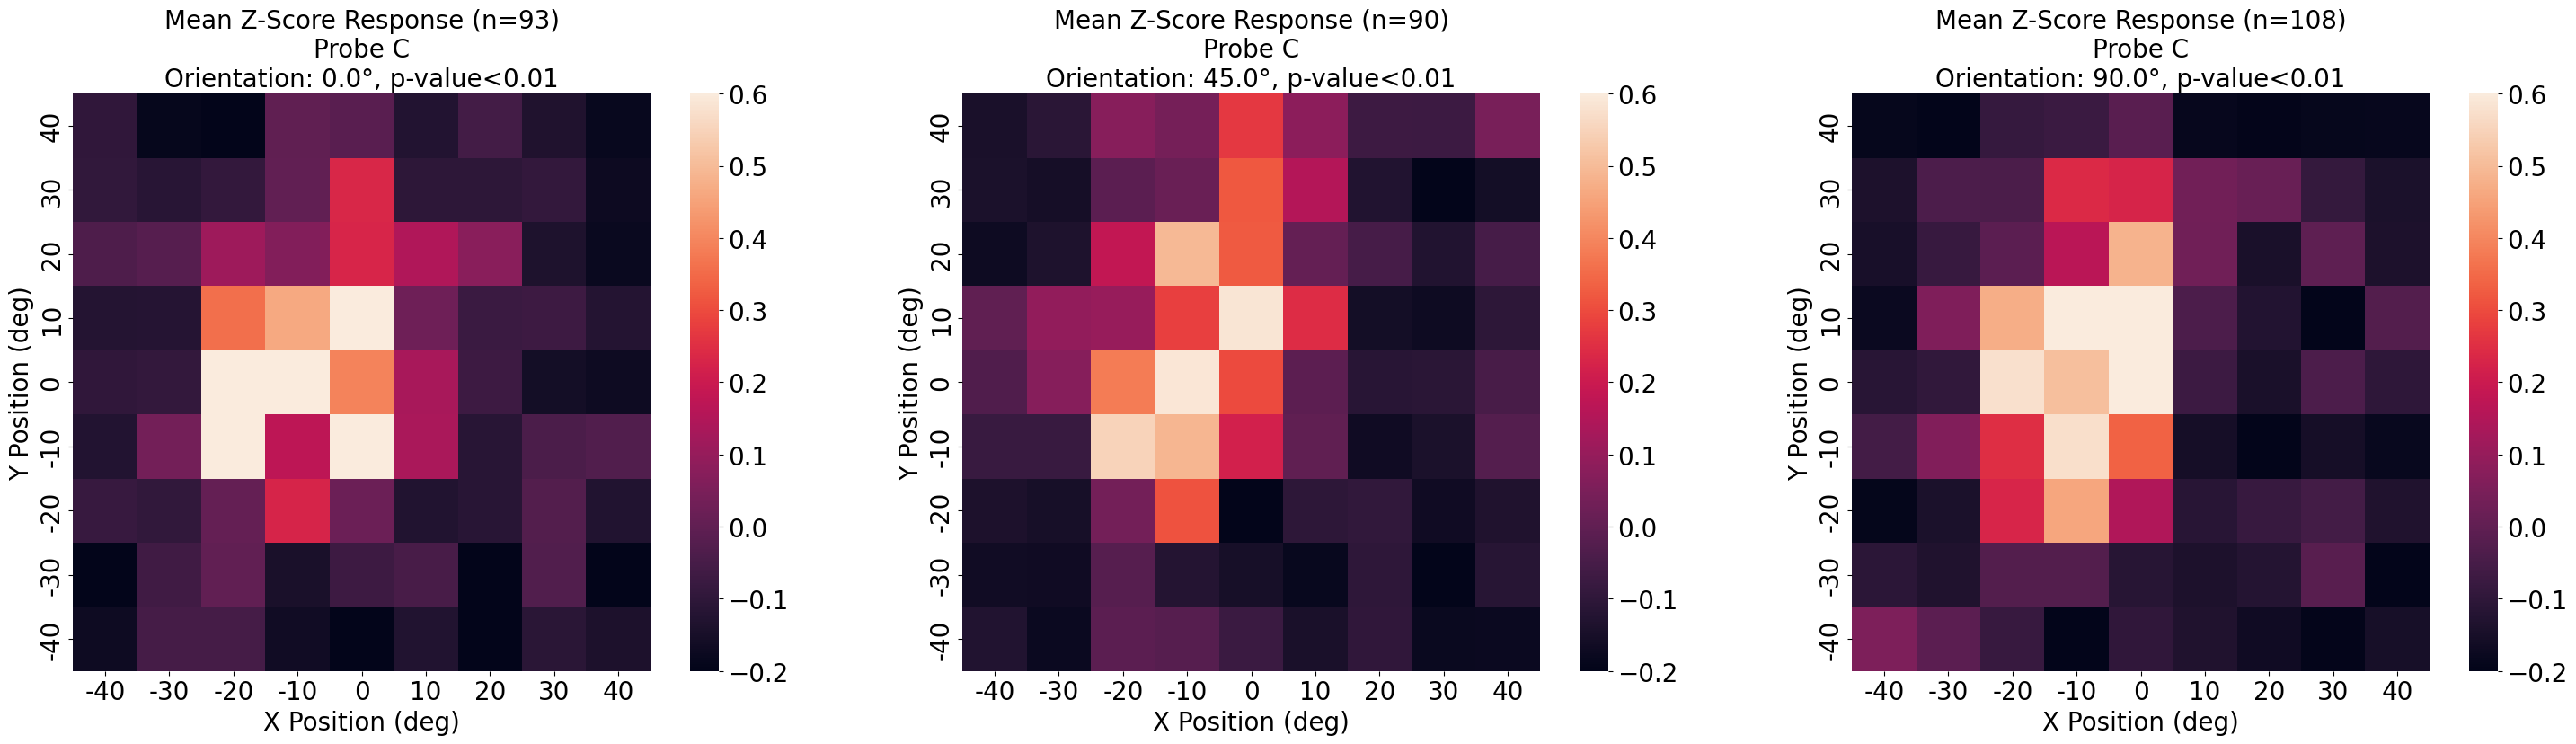

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30,8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    orientation = float(unique_orientations[i])
    p_value_threshold = 0.01
    df_tmp = results_c[(results_c['p_value']<p_value_threshold) & 
                       (results_c['orientation'] == orientation) &
                       (results_c['mean_rate'] > 0)
                    ]
    df_tmp.reset_index(drop=True, inplace=True)

    all_z_responses = df_tmp['z_score_response'].values
    mean = np.mean(all_z_responses, axis=0)

    sns.heatmap(mean, ax=ax,vmin=-.2, vmax=.6)
    _ = ax.set_xticklabels(x_pos.astype(int))
    _ = ax.set_yticklabels(reversed(y_pos.astype(int)))

    ax.set_title(f'Mean Z-Score Response (n={len(df_tmp)})\nProbe C\nOrientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=20)
    ax.set_aspect('equal')
    ax.set_xlabel('X Position (deg)')
    ax.set_ylabel('Y Position (deg)')


fig.tight_layout()

plot_filename = f"mean-z-scored-responses__gabors__probe-c__{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

--- 
## Probe D

In [ ]:
PROBE = 'd'
DELAY = 100 *pq.ms
unit_idx = probe_d[list(probe_c.keys())[0]]

unique_x = np.unique(df_rf['X'])
unique_y = np.unique(df_rf['Y'])
x_pos = np.sort(unique_x.astype(float))
y_pos = np.sort(unique_y.astype(float))
unique_orientations = np.unique(df_rf['Orientation'])
combinations_xy = [(x, y) for x in unique_x for y in unique_y]

results = []
for idx in tqdm(unit_idx):

    unit_name = df_units.loc[idx, 'unit_name']
    spike_times = df_units.loc[idx, 'spike_times']
    spike_times = neo.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

    for orientation in unique_orientations.astype(float):
        R = np.zeros((5, len(x_pos), len(y_pos)))
        for (x,y) in combinations_xy:
            x_i = np.digitize(float(x), x_pos)-1
            y_i = np.digitize(float(y), y_pos)-1

            onsets, offsets = get_stim_onsets_offsets(df_rf, combination_xy=(x,y), orientation=orientation)
            for i, (onset, offset) in enumerate(zip(onsets, offsets)):
                n_spikes = len(time_slice_spike_train(spike_times, onset+DELAY, offset))
                R[i, x_i, y_i] = n_spikes / ((offset - onset - DELAY).rescale(s).magnitude)
            
            
        E = np.mean(R)  # Grand mean - add small value to avoid division by zero
        O = np.mean(R, axis=0) # mean response grid
        chi_squared = np.sum((O - E)**2 / (E+1e-10))

        n_shuffle = 1000
        chi_squared_shuffled = np.zeros(n_shuffle)
        for i in range(n_shuffle):
            R_shuffled = np.random.permutation(R.flatten())
            R_shuffled = R_shuffled.reshape(R.shape)
            O_shuffled = np.mean(R_shuffled, axis=0)
            chi_squared_shuffled[i] = np.sum((O_shuffled - E)**2 / (E+1e-10))

        p_value = (np.sum(chi_squared_shuffled > chi_squared)+1 ) / (n_shuffle+1)

        std = np.std(R)
        z_score_response = (O - E) / (std+1e-10)  # add small value to avoid division by zero

        results.append(pd.DataFrame({
                                'unit_name': [unit_name],
                                'file': [dandi_filepath],
                                'mean_response' : [E],
                                'z_score_response': [z_score_response],
                                'orientation': [orientation],
                                'p_value': [p_value],
                                'mean_rate': [np.mean(R)],
                                'probe': [PROBE],
                                })
        )

100%|██████████| 632/632 [11:29<00:00,  1.09s/it]


In [ ]:
results_d = pd.concat(results, ignore_index=True)
results_d

,unit_name,file,mean_response,z_score_response,orientation,p_value,mean_rate,probe
0,a27878d3-cda8-47d6-b798-1eb3031f7248,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,32.715341,"[[0.3794738931492211, -0.15307929201481996, -0...",0.000000,0.527473,32.715341,d
1,a27878d3-cda8-47d6-b798-1eb3031f7248,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,31.187540,"[[0.8935534918994762, -0.07057678323289411, -0...",0.785398,0.855145,31.187540,d
2,a27878d3-cda8-47d6-b798-1eb3031f7248,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,32.330017,"[[-0.1399855604908349, -0.5646899566940907, -0...",1.570796,0.483516,32.330017,d
3,deddb367-3657-4082-aaf0-0394394514b2,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.292087,"[[0.2921005741543531, 0.2920914922243104, -0.3...",0.000000,0.451548,1.292087,d
4,deddb367-3657-4082-aaf0-0394394514b2,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.081666,"[[0.3680339857934205, 0.03266108557111461, -0....",0.785398,0.028971,1.081666,d
...,...,...,...,...,...,...,...,...
1891,55368479-8b12-48f0-97fa-bd67d6d90225,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,9.861588,"[[-0.3501401975964393, -0.5072351883562023, 0....",0.785398,0.667333,9.861588,d
1892,55368479-8b12-48f0-97fa-bd67d6d90225,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,9.463771,"[[-0.5070213990810302, -0.15700570641843703, 0...",1.570796,0.589411,9.463771,d
1893,2ce6e328-e725-4934-8677-c259f506700c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,2.181420,"[[0.05601185010216185, -0.25569959109945917, 0...",0.000000,0.474525,2.181420,d
1894,2ce6e328-e725-4934-8677-c259f506700c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,2.128813,"[[-0.5845054090457353, -0.2554691327789291, 0....",0.785398,0.965035,2.128813,d


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/2802945798.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Estimated X Position ($\mu$m)')
/tmp/ipykernel_42220/2802945798.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Estimated Y Position ($\mu$m)')


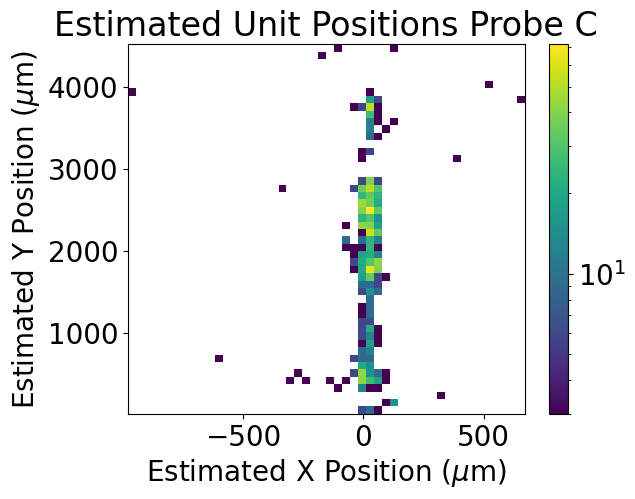

In [ ]:
results_d['estimated_x'] = results_d['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_x'].values[0])
results_d['estimated_y'] = results_d['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_y'].values[0])
results_d['estimated_z'] = results_d['unit_name'].apply(lambda unit: df_units.loc[df_units['unit_name'] == unit, 'estimated_z'].values[0])

fig = plt.figure()
ax = fig.add_subplot()

hist = ax.hist2d(results_d['estimated_x'], results_d['estimated_y'], bins=50, cmap='viridis', norm=mpl.colors.LogNorm())
ax.set_xlabel('Estimated X Position ($\mu$m)')
ax.set_ylabel('Estimated Y Position ($\mu$m)')
ax.set_title('Estimated Unit Positions Probe C')
fig.colorbar(hist[3], ax=ax)

(array([ 6.,  7.,  5.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,
         0.,  5., 18., 10., 18., 14., 19.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 123.18      ,  258.54633333,  393.91266667,  529.279     ,
         664.64533333,  800.01166667,  935.378     , 1070.74433333,
        1206.11066667, 1341.477     , 1476.84333333, 1612.20966667,
        1747.576     , 1882.94233333, 2018.30866667, 2153.675     ,
        2289.04133333, 2424.40766667, 2559.774     , 2695.14033333,
        2830.50666667, 2965.873     , 3101.23933333, 3236.60566667,
        3371.972     , 3507.33833333, 3642.70466667, 3778.071     ,
        3913.43733333, 4048.80366667, 4184.17      ]),
 <BarContainer object of 30 artists>)

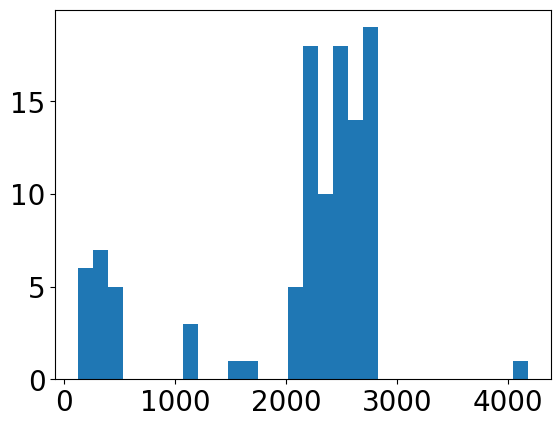

In [ ]:
plt.hist(df_tmp['estimated_y'], bins=30)

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/4181950881.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/4181950881.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/4181950881.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/4181950881.py:65:

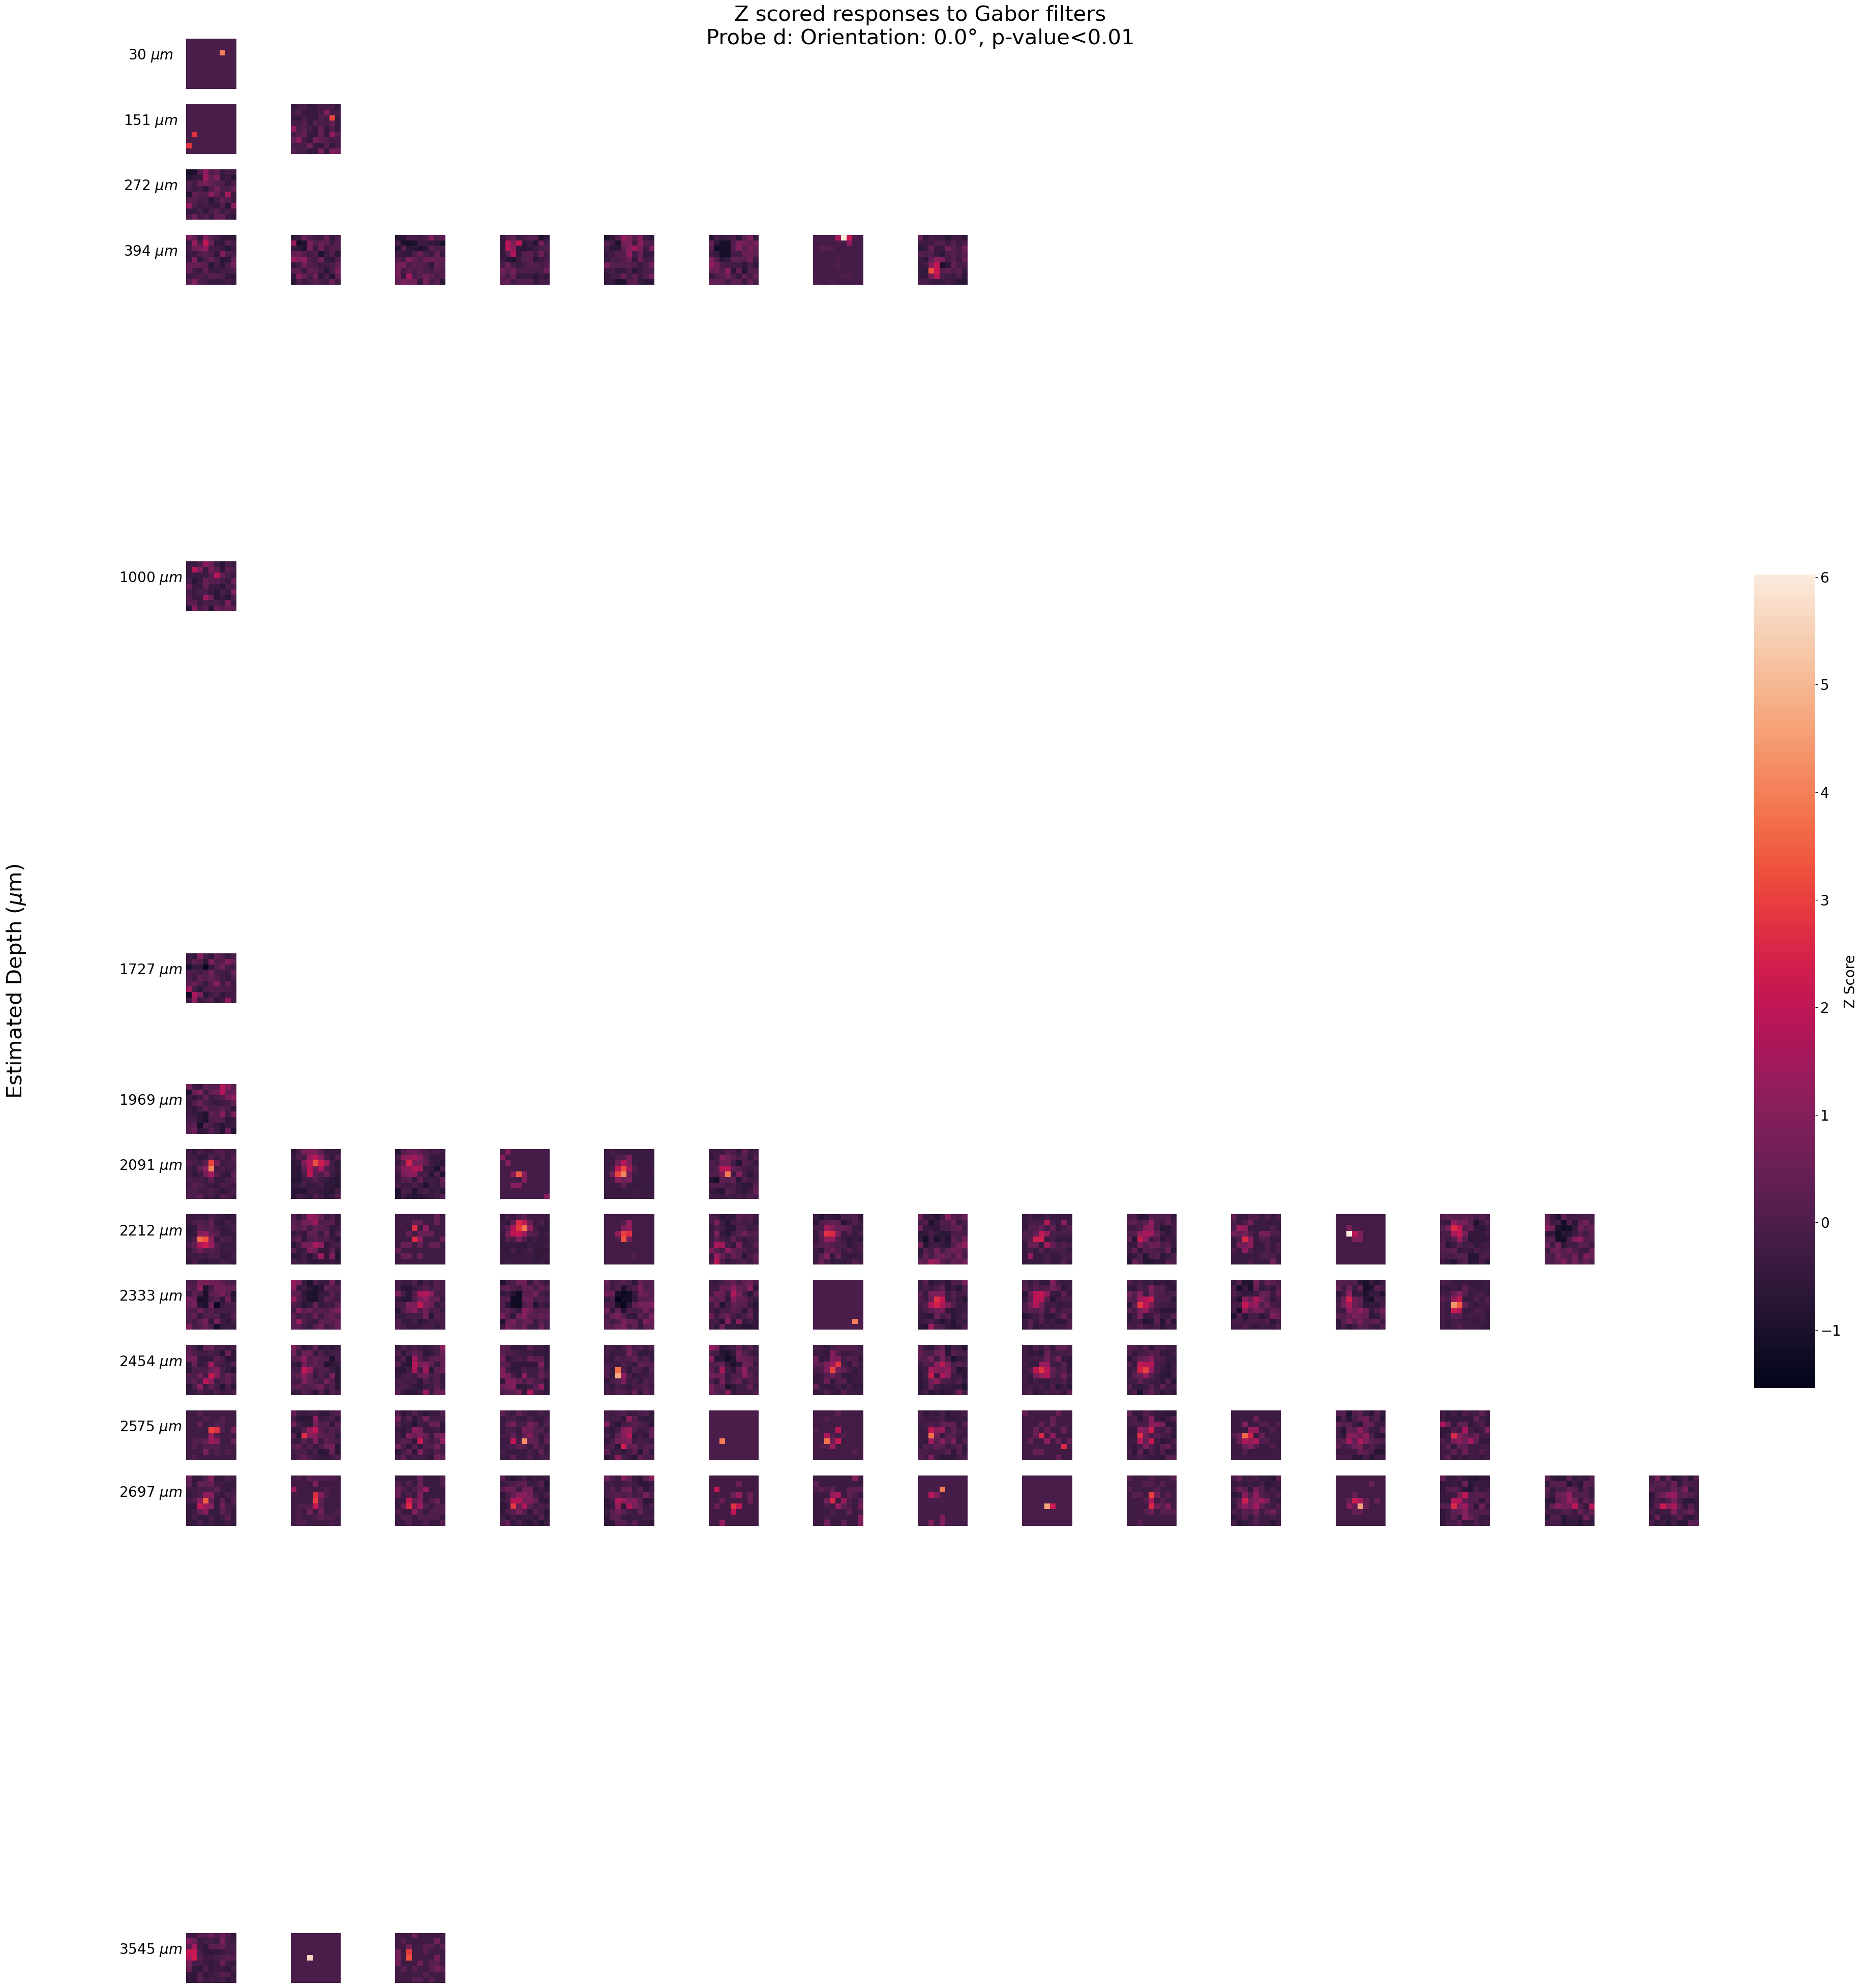

In [71]:
n_ybins = 30
p_value_threshold = 0.01
orientation = 0.0

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe {PROBE}: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-{PROBE}__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/3720727491.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/3720727491.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/3720727491.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/3720727491.py:65:

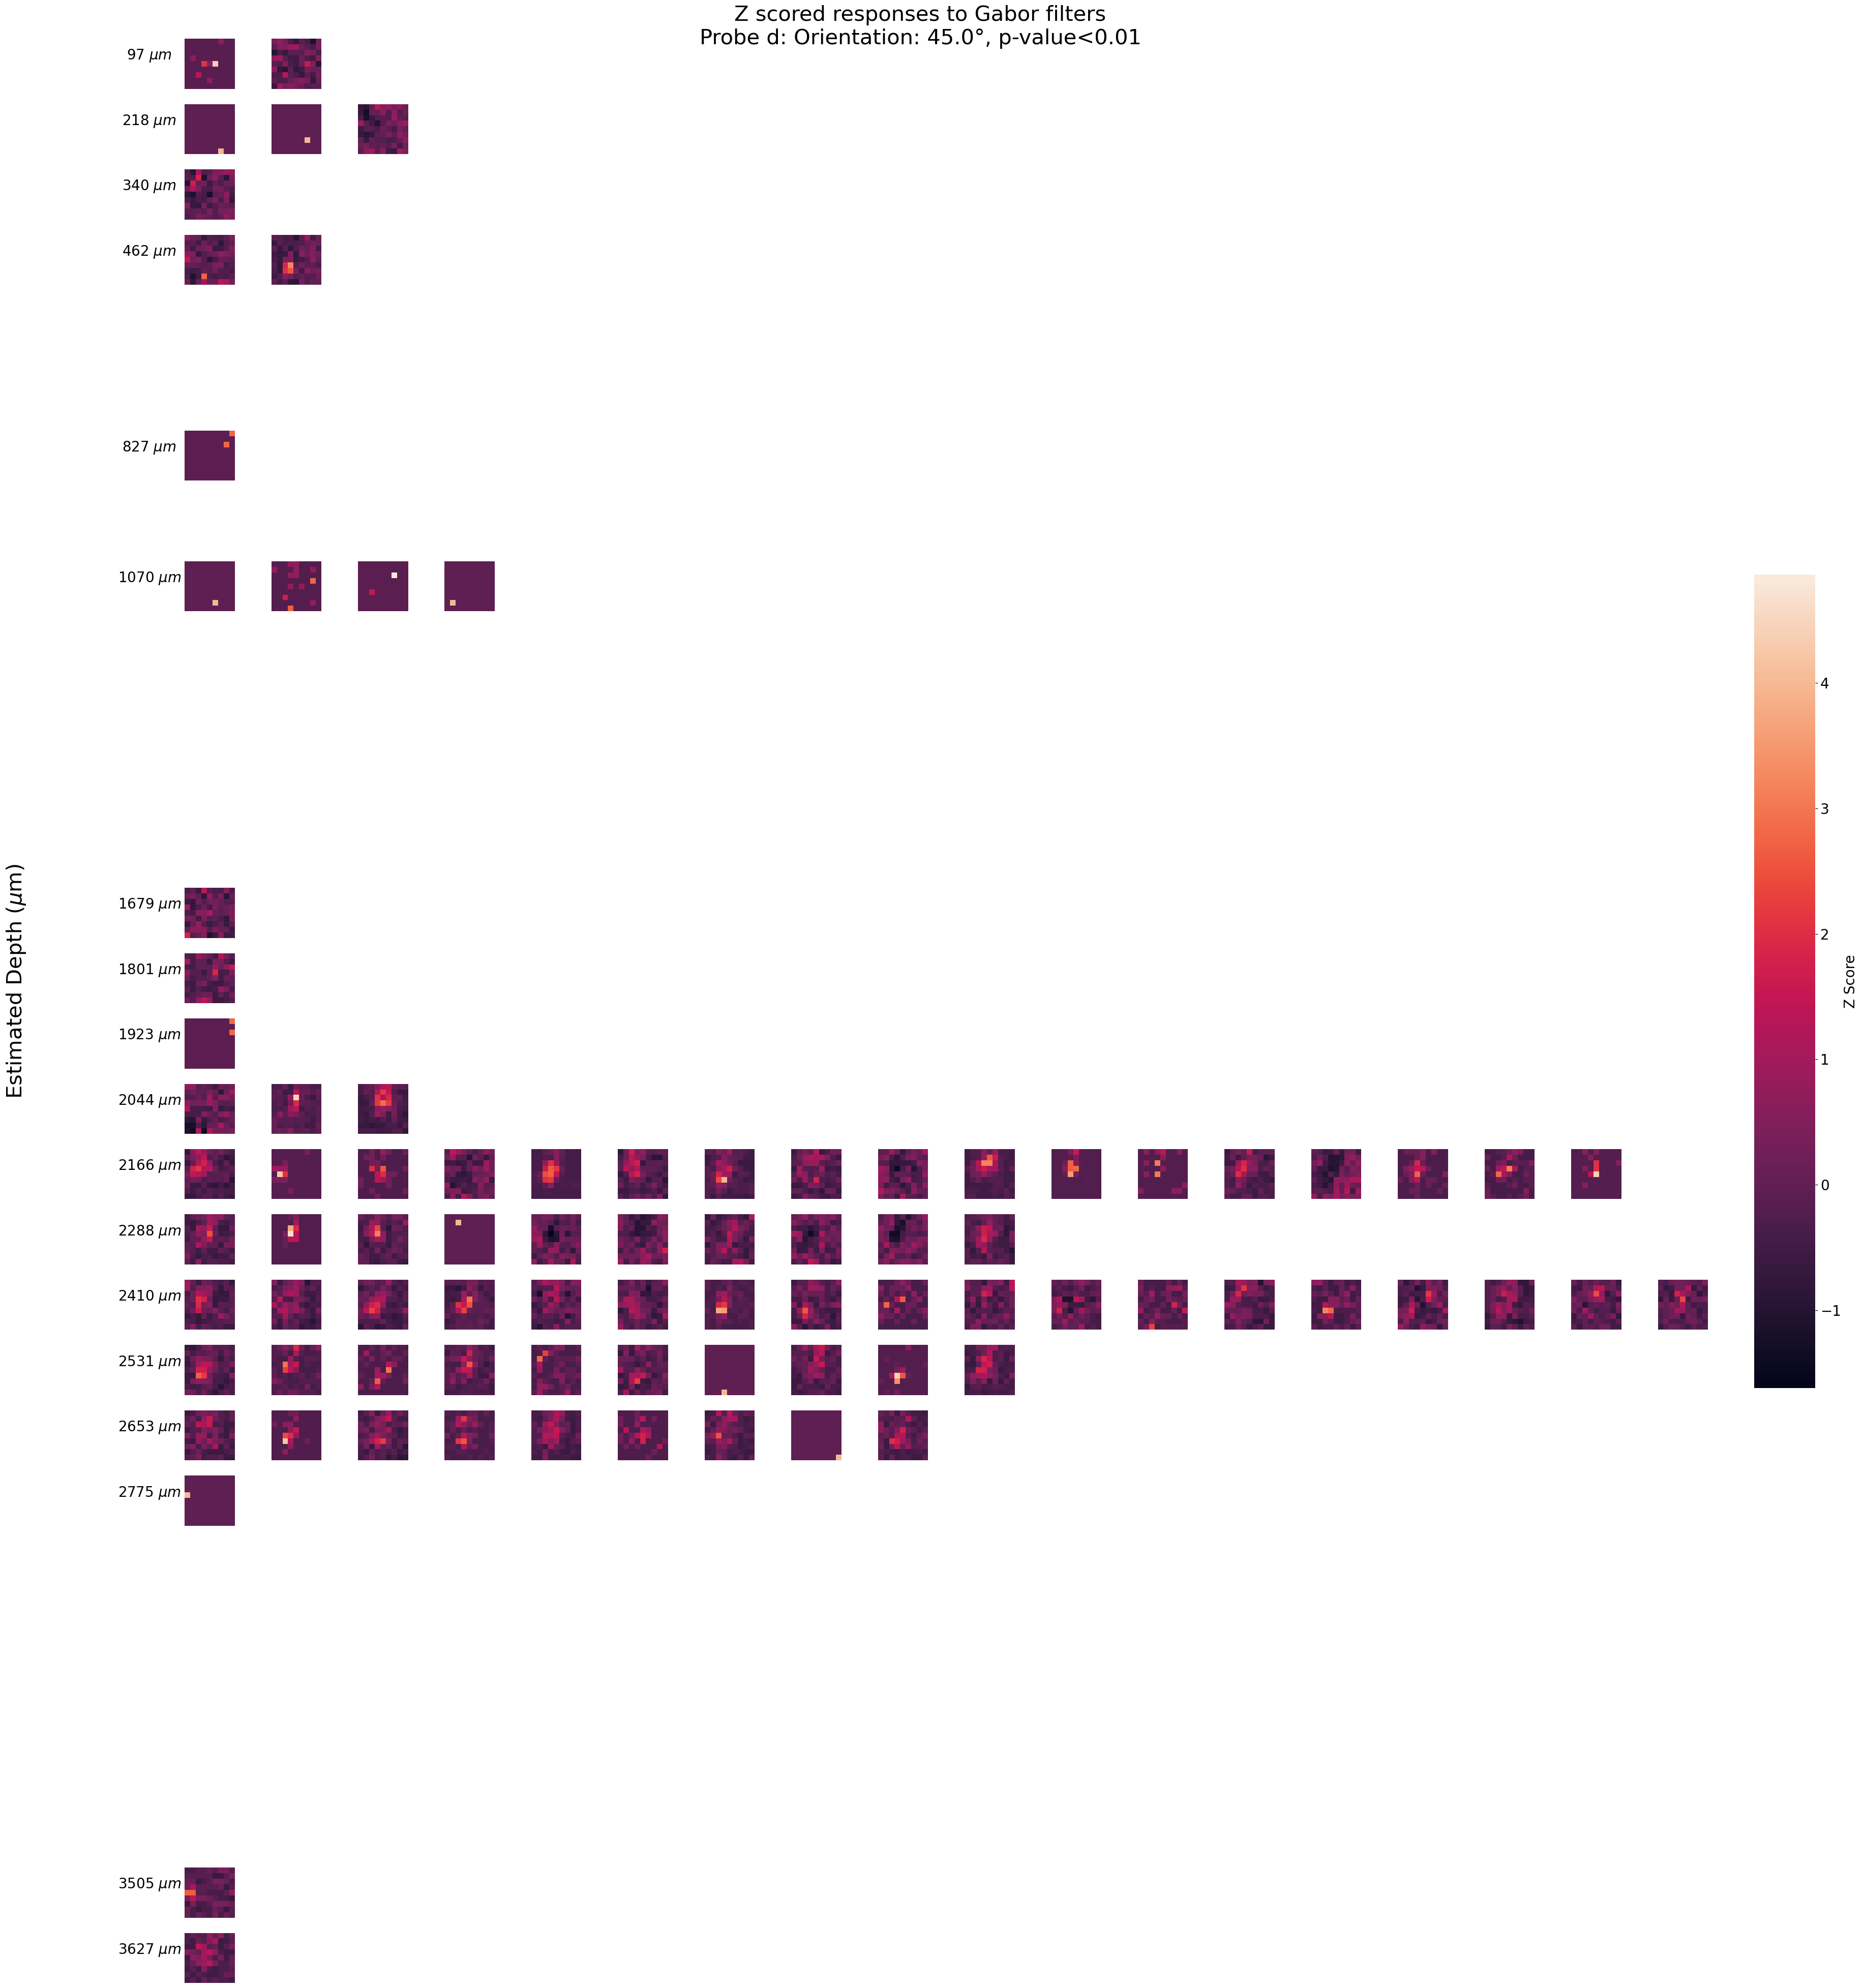

In [72]:

n_ybins = 30
p_value_threshold = 0.01
orientation = float(df_rf['Orientation'].unique()[2]) 

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe {PROBE}: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-{PROBE}__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_42220/3768777208.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
/tmp/ipykernel_42220/3768777208.py:68: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)
/tmp/ipykernel_42220/3768777208.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
/tmp/ipykernel_42220/3768777208.py:65:

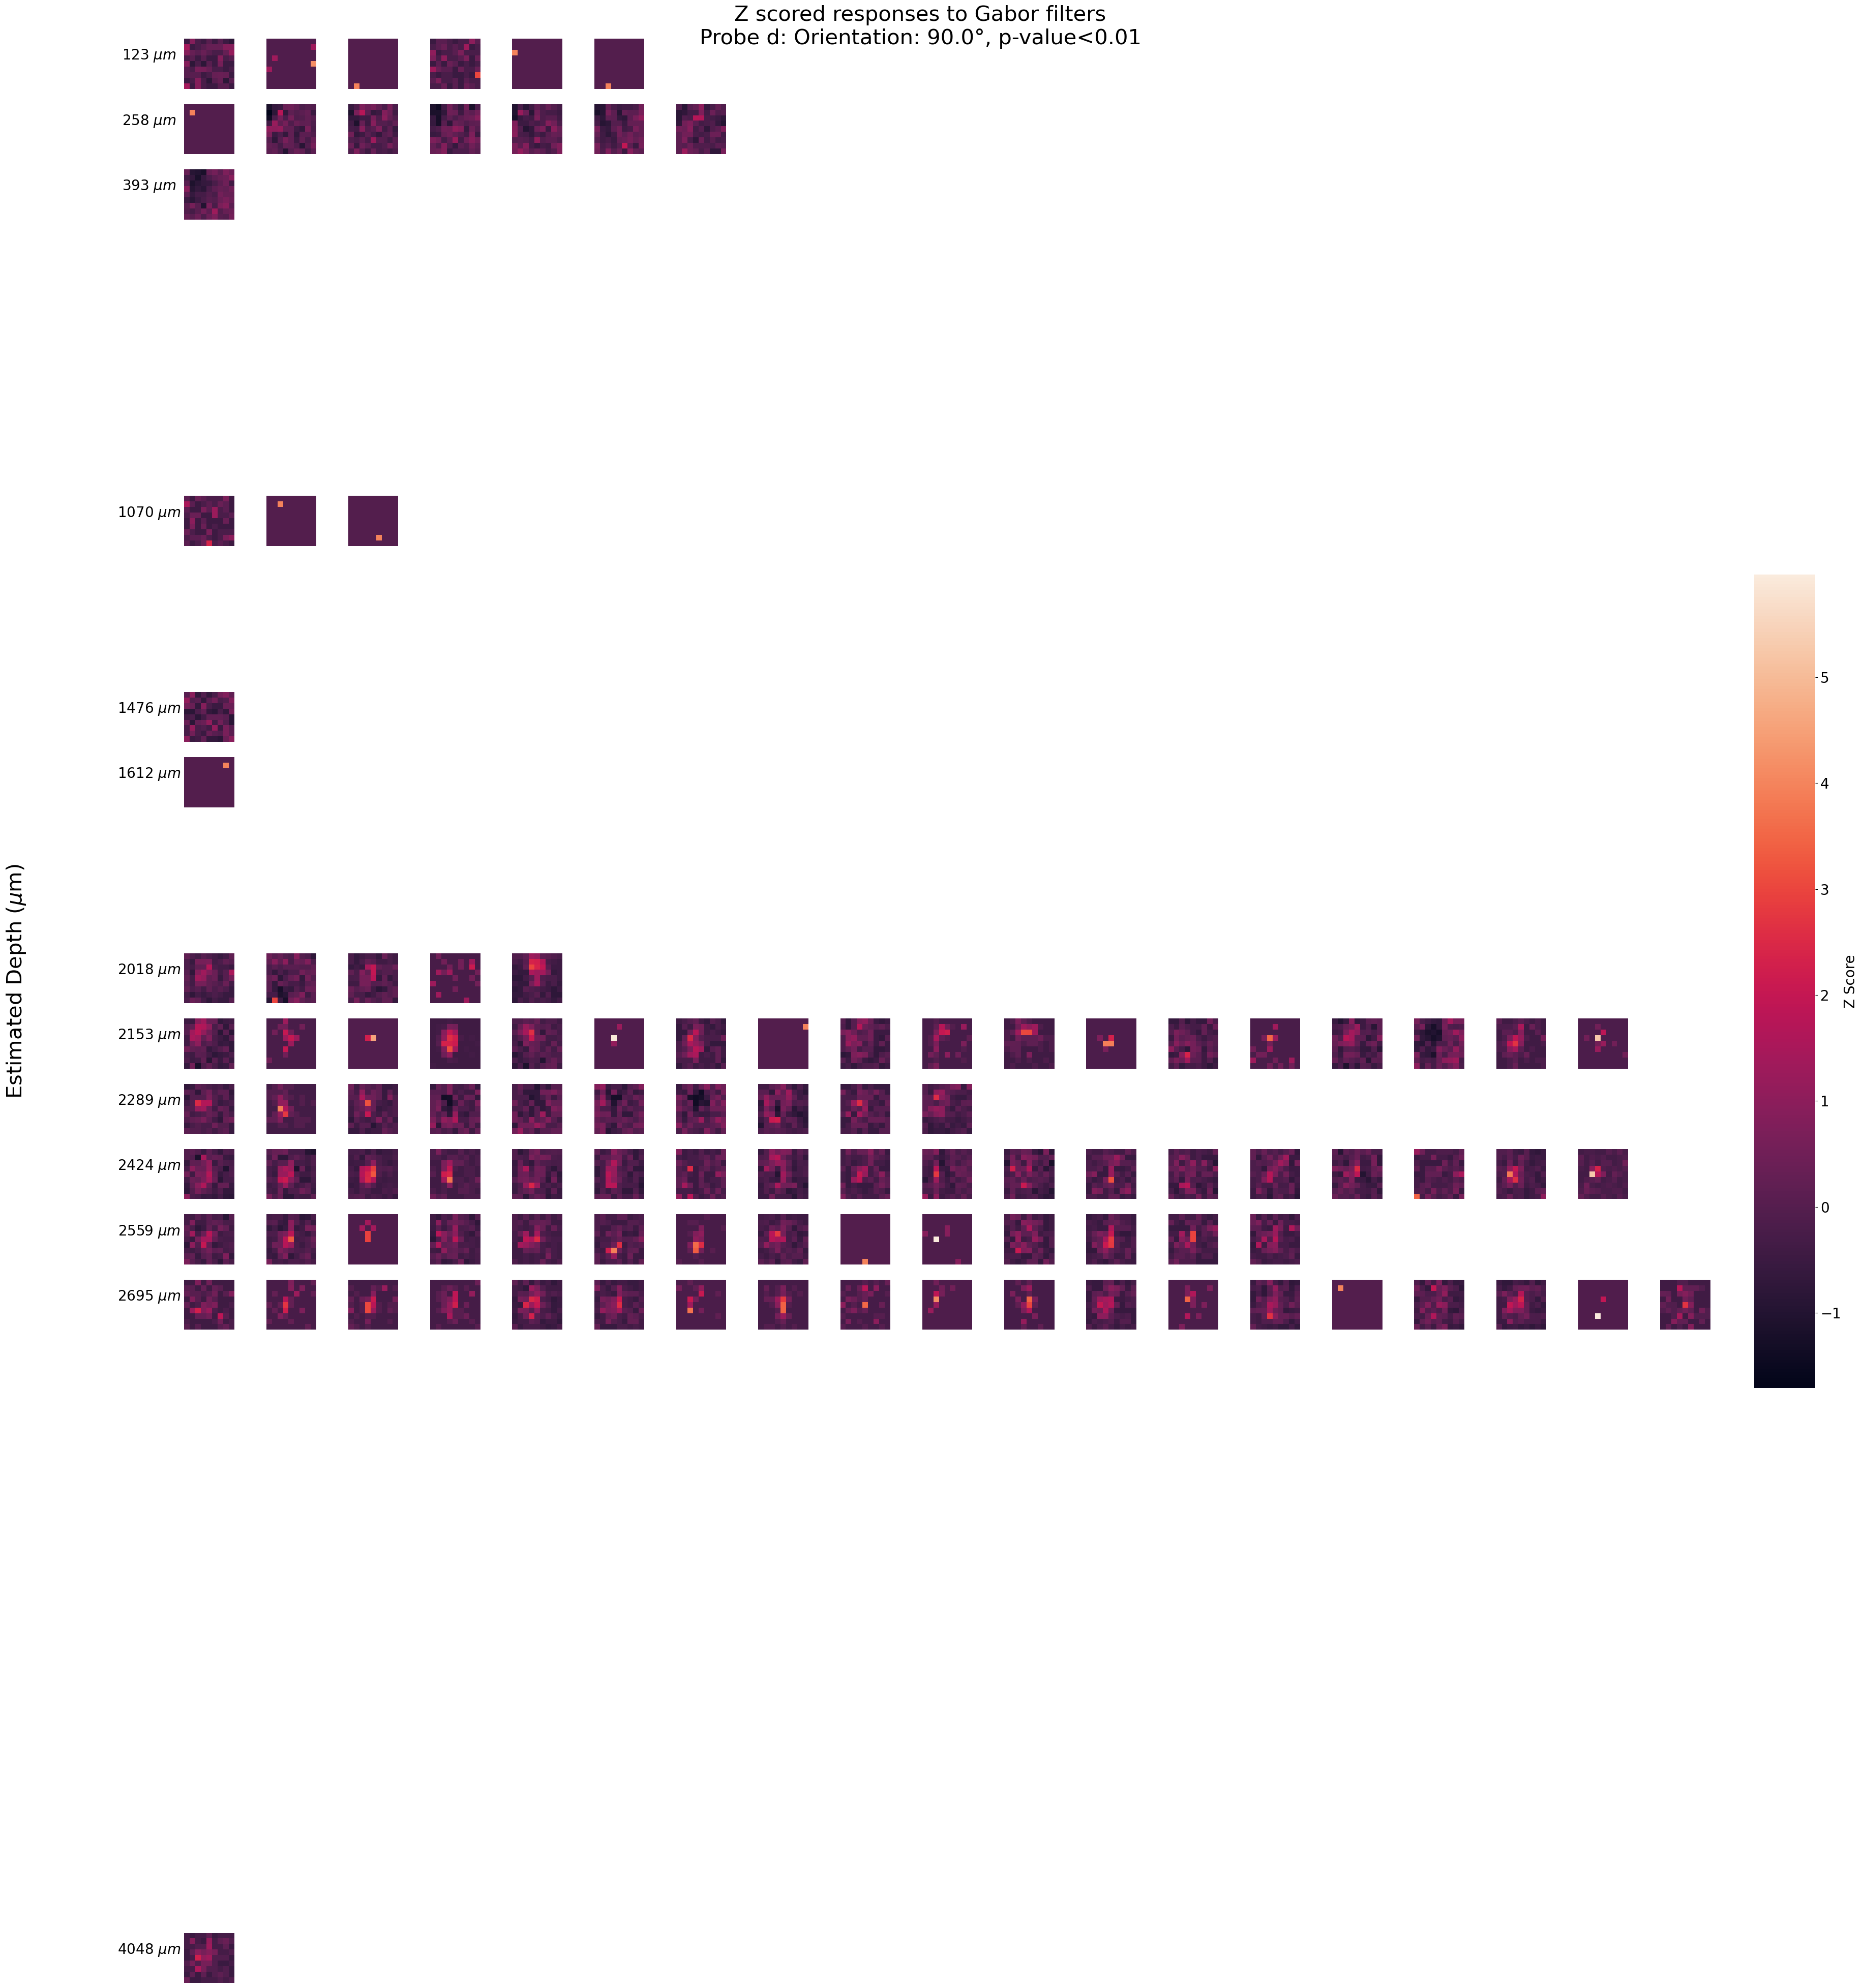

In [76]:

n_ybins = 30
p_value_threshold = 0.01
orientation = float(df_rf['Orientation'].unique()[1]) 

df_tmp = results_c[(results_c['p_value'] < p_value_threshold) &
                   (results_c['orientation'] == orientation) &
                   (results_c['mean_rate'] > 0)
                   ]
df_tmp.reset_index(drop=True, inplace=True)
# df_tmp = df_tmp[:20]

# Bin the estimated_y into 30 bins
df_tmp['y_bin'] = pd.cut(df_tmp['estimated_y'], bins=n_ybins, labels=False)
_, ybin_values = np.histogram(df_tmp['estimated_y'], bins=n_ybins)
y_bin_values = ybin_values + np.diff(ybin_values)[0]

# Sort by y_bin and then by estimated_y within each bin
df_tmp = df_tmp.sort_values(['y_bin', 'estimated_y']).reset_index(drop=True)

vmin = df_tmp['z_score_response'].apply(lambda R: R.min()).min()
vmax = df_tmp['z_score_response'].apply(lambda R: R.max()).max()
# Group the data by y_bin and ensure each plot is placed in the correct row

nx = df_tmp['y_bin'].value_counts().max()
ny = n_ybins  
N = nx * ny
fig, axs = plt.subplots(ny, nx, figsize=(40, 40))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for y_bin in df_tmp['y_bin'].unique():
    # Iterate over y bins
    df_sub = df_tmp[df_tmp['y_bin'] == y_bin]
    df_sub.reset_index(drop=True, inplace=True)
    for i_col, row in df_sub.iterrows():
        ax = axs[y_bin, i_col]

        z_score = row['z_score_response']
        sns.heatmap(z_score, ax=ax,
                    cbar=True if y_bin == i_col == 0 else False, # only plot 1st colorbar
                    cbar_ax=cbar_ax if y_bin == i_col == 0 else False,
                    vmin=vmin,
                    vmax=vmax,
                    cbar_kws={'label': 'Z Score'}
                    )
        #   # Turn off unused axes
        ax.set_aspect('equal')

        # Add y-label to the first plot of each row
        if i_col == 0:
            ax.set_ylabel(f"{int(ybin_values[y_bin])} $\mu m$", rotation='horizontal', labelpad=50)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
        if y_bin == 2:
            break


for ax in axs.flatten():
    if not ax.has_data():
        ax.remove()

fig.suptitle(f'Z scored responses to Gabor filters\nProbe {PROBE}: Orientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=30)
fig.tight_layout(rect=[.1, 0, .9, 1])

# Add text and an arrow pointing down to the left of the plot
fig.text(0.05, 0.5, 'Estimated Depth ($\mu$m)', va='center', rotation='vertical', fontsize=30)

plot_filename = f"z-scored-responses__gabors__probe-{PROBE}__orientation-{int(np.rad2deg(orientation))}-{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

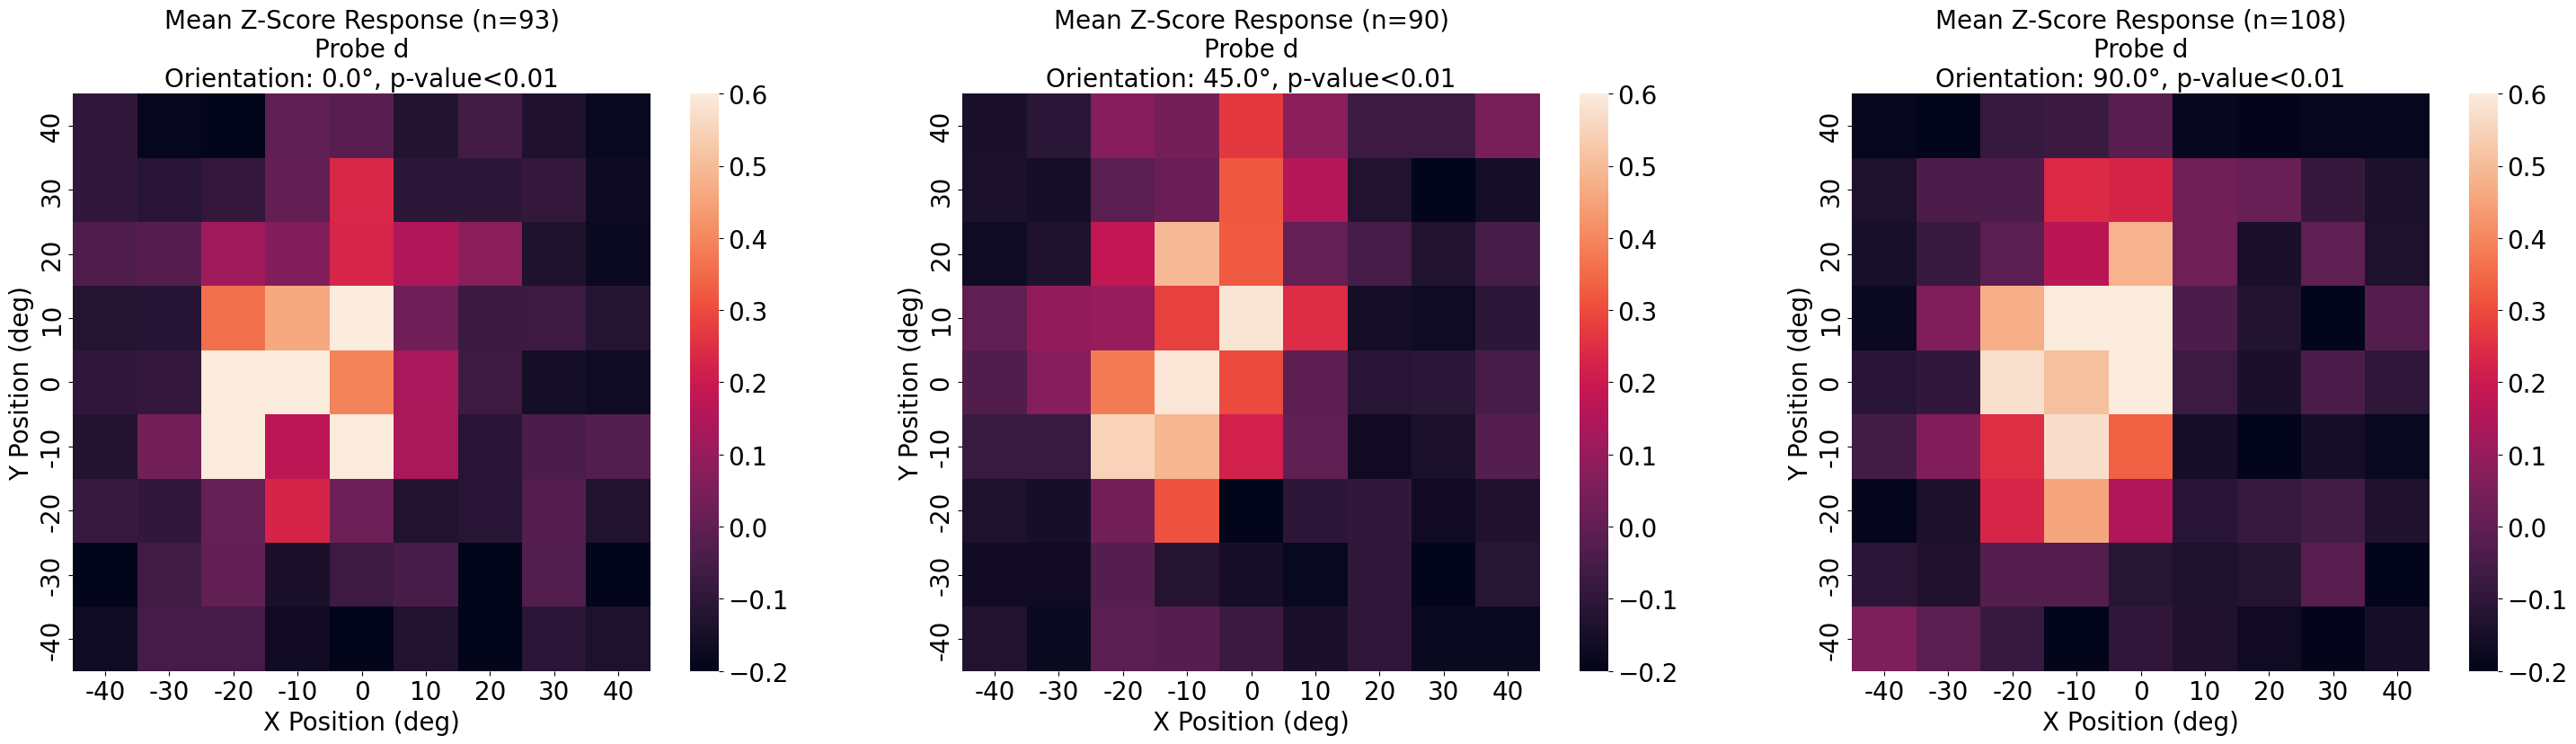

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(30,8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    orientation = float(unique_orientations[i])
    p_value_threshold = 0.01
    df_tmp = results_c[(results_c['p_value']<p_value_threshold) & 
                       (results_c['orientation'] == orientation) &
                       (results_c['mean_rate'] > 0)
                    ]
    df_tmp.reset_index(drop=True, inplace=True)

    all_z_responses = df_tmp['z_score_response'].values
    mean = np.mean(all_z_responses, axis=0)

    sns.heatmap(mean, ax=ax,vmin=-.2, vmax=.6)
    _ = ax.set_xticklabels(x_pos.astype(int))
    _ = ax.set_yticklabels(reversed(y_pos.astype(int)))

    ax.set_title(f'Mean Z-Score Response (n={len(df_tmp)})\nProbe {PROBE}\nOrientation: {np.rad2deg(orientation)}°, p-value<{p_value_threshold}', fontsize=20)
    ax.set_aspect('equal')
    ax.set_xlabel('X Position (deg)')
    ax.set_ylabel('Y Position (deg)')


fig.tight_layout()

plot_filename = f"mean-z-scored-responses__gabors__probe-{PROBE}__{filename}.png"
results_dir = '../../results/allen_open_scope/rf/siegle/gabors/plots/'
fig.savefig(results_dir+plot_filename, dpi=600, bbox_inches='tight')

---
## RESPONSE TIMES

In [ ]:
# Load siegle gabors results

RESULTS_DIR = '../../results/allen_open_scope/rf/siegle/gabors/'
filenames = os.listdir(RESULTS_DIR)


dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(RESULTS_DIR+filename))

df_res = pd.concat(dfs, ignore_index=True)
df_res = df_res.drop(df_res[df_res['size']==81].index)  # remove size 81
df_res.reset_index(inplace=True, drop=True)
df_res

,unit_name,file,x,y,size,orientation,p_value,mean_rate
0,cd5812db-8fa5-4a96-8ca3-b292543c3a19,sub-820454/sub-820454_ses-ecephys-820454-2025-...,2.000000,8.000000,3,0.785398,0.032967,0.268292
1,fae38945-a687-404a-a828-473c4afcf8d7,sub-820454/sub-820454_ses-ecephys-820454-2025-...,5.000000,6.000000,1,0.000000,0.003996,0.148023
2,9d559d0f-d71e-4df7-8a90-7e57724caa24,sub-820454/sub-820454_ses-ecephys-820454-2025-...,7.666667,5.666667,3,1.570796,0.025974,3.707987
3,ea045609-3d9b-449e-ba61-e16c2646414e,sub-820454/sub-820454_ses-ecephys-820454-2025-...,7.500000,8.000000,2,0.785398,0.036963,12.401277
4,ac1db2c4-f323-4551-9e02-3f38c25454b7,sub-820454/sub-820454_ses-ecephys-820454-2025-...,0.000000,3.500000,2,0.000000,0.025974,0.880123
...,...,...,...,...,...,...,...,...
8381,5de5f359-b013-4810-9c03-9d13a665ab7b,sub-820454/sub-820454_ses-ecephys-820454-2025-...,1.416667,5.750000,12,0.785398,0.000999,29.815011
8382,5de5f359-b013-4810-9c03-9d13a665ab7b,sub-820454/sub-820454_ses-ecephys-820454-2025-...,1.285714,5.571429,7,1.570796,0.000999,32.288876
8383,efa2016b-661f-4b70-bb9d-158f471ac75a,sub-820454/sub-820454_ses-ecephys-820454-2025-...,0.000000,3.500000,2,0.785398,0.000999,0.407682
8384,efa2016b-661f-4b70-bb9d-158f471ac75a,sub-820454/sub-820454_ses-ecephys-820454-2025-...,1.000000,4.500000,6,1.570796,0.001998,0.527334


In [ ]:
df_res[df_res['size']==1].sort_values('mean_rate', ascending=False).index[0]

np.int64(5475)

In [ ]:
idx = df_res[df_res['size']==1].sort_values('mean_rate', ascending=False).index[111]

file_tmp = df_res.loc[idx, 'file']
unit_id_tmp = df_res.loc[idx, 'unit_name']

dandi_filepath = file_tmp.split('/')[-1]
dandiset_id = utils.dandiset_id
dandi_dirpath = utils.dandi_dirpath
nwb = utils.load_dandi(dandi_filepath, dandiset_id, dandi_dirpath)
df_units = nwb.units.to_dataframe()

spike_times  = df_units.loc[df_units['unit_name'] == unit_id_tmp, 'spike_times'].values[0]
spike_times = neo.SpikeTrain(spike_times, units='s', t_start=spike_times[0], t_stop=spike_times[-1])
df_rf = nwb.intervals['RF mapping_presentations'].to_dataframe()

x_poss = np.sort(df_rf["X"].unique().astype(float))
y_poss = np.sort(df_rf["Y"].unique().astype(float))

Processing file: sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/allen/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed us

In [ ]:
def get_stim_onsets(df_rf, combination):
    x, y, orientation = combination
    df_sub = df_rf[
        (df_rf['X'] == str(float(x))) &
        (df_rf['Y'] == str(float(y))) &
        (df_rf['Orientation'] == str(float(orientation)))
    ]
    return df_sub['start_time'].values

x = df_res.loc[idx, 'x']
y = df_res.loc[idx, 'y']

x = x_poss[int(x)]
y = y_poss[int(y)]


orientation = df_res.loc[idx, 'orientation']

onsets_gabors = get_stim_onsets(df_rf, (x,y,orientation))
onsets_gabors = onsets_gabors*pq.s
onsets_gabors

array([4089.80921538, 4108.99202222, 4112.97871626, 4337.60108745,
       4375.69982012]) * s

In [ ]:
def get_spikes_to_onsets(spike_times, onsets, pre_time=0.5*pq.s, post_time=1*pq.s):
    spike_trains = []
    for onset in onsets:
        st = spike_times.time_slice(onset - pre_time, onset + post_time)
        spike_trains.append(st.time_shift(-onset))
    return spike_trains



Text(0, 0.5, 'Trials')

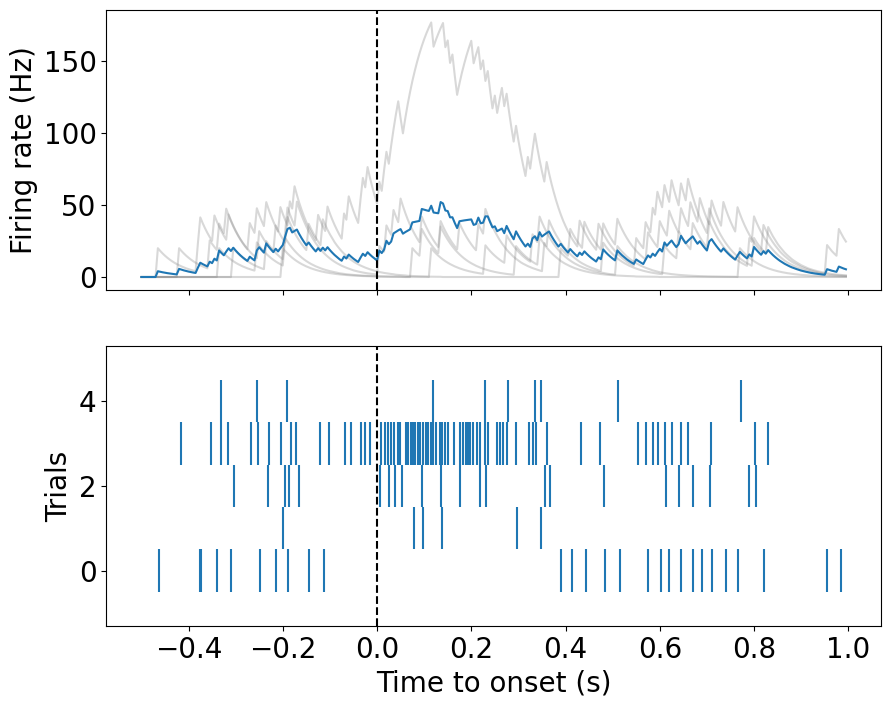

In [ ]:
f, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

spike_trains_gabors = get_spikes_to_onsets(spike_times, onsets_gabors)
raster_gabors = eleph.statistics.time_histogram(spike_trains_gabors, bin_size=20*ms)

spike_densities = []
for st in spike_trains_gabors:
    sd = eleph.statistics.instantaneous_rate(spiketrain=st,    
                                            sampling_period=5*pq.ms,
                                            kernel=eleph.kernels.ExponentialKernel(sigma=50*pq.ms),
                                            center_kernel=False,
                                            )
    spike_densities.append(sd)


mean = np.mean(spike_densities, axis=0)


for sd in spike_densities:
    axs[0].plot(sd.times, sd.magnitude, color='gray', alpha=0.3)
axs[0].plot(sd.times, mean)
_ = axs[1].eventplot([st.times for st in spike_trains_gabors])

for ax in axs:
    ax.axvline(0, color='k', linestyle='--')

axs[1].set_xlabel('Time to onset (s)')
axs[0].set_ylabel('Firing rate (Hz)')
axs[1].set_ylabel('Trials')